In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import os
import sys
import umap
import sklearn.metrics

from tqdm import tqdm
import matplotlib.pyplot as plt

sys.path.append("../profiling/")
import profiling

In [2]:
PROJECT_ROOT = "/raid/data/cellpainting/TAORF/"

EXP = "efn_plate_grouping_8bs"

OUTPUT_FILE = "data/efn_plate_grouping_8bs-conv6a.csv"

# Load single cell data

In [3]:
# Load metadata
meta = pd.read_csv(os.path.join(PROJECT_ROOT, "inputs/metadata/index.csv"))
scmeta = pd.read_csv(os.path.join(PROJECT_ROOT, "outputs/single_cell_masks/sc-metadata-expanded.csv"))

/opt/tljh/user/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: DtypeWarning: Columns (19) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
features = []
locations = []
metadata = []
for i in tqdm(meta.index):
    filename = PROJECT_ROOT + "outputs/" + EXP + "/features/{}/{}/{}.npz"
    filename = filename.format(
        meta.loc[i, "Metadata_Plate"], 
        meta.loc[i, "Metadata_Well"], 
        meta.loc[i, "Metadata_Site"]
    )
    if os.path.isfile(filename):
        with open(filename, "rb") as data:
            info = np.load(data, allow_pickle=True)
            features.append(info["features"])
            locations.append(info["locations"])
            metadata.append(info["metadata"])
    else:
        features.append([])
        locations.append([])
        metadata.append([])

100%|██████████| 17273/17273 [00:34<00:00, 504.70it/s]


In [5]:
total_single_cells = 0
for i in range(len(features)):
    if len(features[i]) > 0:
        total_single_cells += features[i].shape[0]

print("Total images",len(features),features[0].shape)
print("Total single cells:", total_single_cells)

Total images 17273 (22, 206)
Total single cells: 883098


# Create predictions dataframe

In [15]:
scdata = []
for i in tqdm(range(len(locations))):
    if(len(locations[i])) == 0:
        continue
    row = {
        "Metadata_Plate": metadata[i][()]["Metadata_Plate"],
        "Metadata_Well": metadata[i][()]["Metadata_Well"],
        "Metadata_Site": metadata[i][()]["Metadata_Site"]
    }
    mdf = pd.DataFrame([row]*len(locations[i]))
    ldf = pd.DataFrame(locations[i], columns=["Nuclei_Location_Center_X", "Nuclei_Location_Center_Y", "Orientation"])
    fdf = pd.DataFrame(features[i])
    
    scdata.append(pd.concat([mdf, ldf, fdf], axis=1))

100%|██████████| 17273/17273 [00:27<00:00, 618.09it/s]


In [16]:
scdata = pd.concat(scdata)
fullset = pd.merge(scdata, scmeta, on=["Metadata_Plate", "Metadata_Well", "Metadata_Site", "Nuclei_Location_Center_X", "Nuclei_Location_Center_Y", "Orientation"])

In [17]:
class_names = scmeta[scmeta.Training_Status == "Training"].pert_name.unique()
class_names.sort()
class_names = {x:y for x,y in zip(range(len(class_names)), class_names)}
class_ids = {y:x for x,y in class_names.items()}

In [18]:
fullset["MaxProb"] = fullset[[x for x in range(len(class_names))]].idxmax(axis=1)
fullset["Prediction"] = fullset["MaxProb"].apply(lambda x: class_names[x] if not np.isnan(x) else "NA")

# Evaluate predictions

In [19]:
training_set = fullset[fullset.Training_Status == "Training"]
validation_set = fullset[fullset.Training_Status.isin(["Validation", "HoldOut"])]

In [65]:
train_result = sklearn.metrics.classification_report(training_set["pert_name"], training_set["Prediction"], output_dict=True)
train_result = pd.DataFrame(data=train_result).transpose()
train_result

/home/jupyter-jcaicedo@broadinst-d9764/.local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


,precision,recall,f1-score,support
ACVR1B_WT.1,0.097654,0.152924,0.119194,1334.000000
ACVR1B_WT.3,0.108519,0.096920,0.102392,1104.000000
AKT1S1_WT.1,0.116004,0.157664,0.133663,1370.000000
AKT1S1_WT.2,0.079437,0.353304,0.129710,1135.000000
AKT1_WT.1,0.099835,0.170572,0.125952,1067.000000
...,...,...,...,...
YAP1_WT.3,0.092091,0.107256,0.099096,1585.000000
YAP1_WT.4,0.121029,0.246305,0.162305,1624.000000
accuracy,0.116051,0.116051,0.116051,0.116051
macro avg,0.115597,0.145500,0.109581,344272.000000


In [67]:
val_result = sklearn.metrics.classification_report(validation_set["pert_name"], validation_set["Prediction"], output_dict=True)
val_result = pd.DataFrame(data=val_result).transpose()
val_result

,precision,recall,f1-score,support
ACVR1B_WT.1,0.020604,0.046012,0.028463,978.000000
ACVR1B_WT.3,0.018727,0.011574,0.014306,864.000000
AKT1S1_WT.1,0.053215,0.055300,0.054237,868.000000
AKT1S1_WT.2,0.058386,0.337121,0.099534,792.000000
AKT1_WT.1,0.025360,0.089572,0.039528,748.000000
...,...,...,...,...
YAP1_WT.3,0.023112,0.017503,0.019920,857.000000
YAP1_WT.4,0.038369,0.063872,0.047940,1002.000000
accuracy,0.043872,0.043872,0.043872,0.043872
macro avg,0.038967,0.056398,0.036443,221597.000000


/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


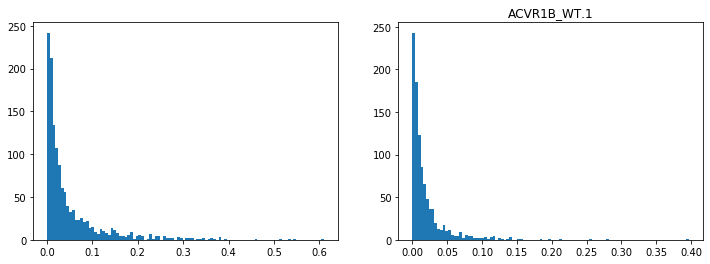

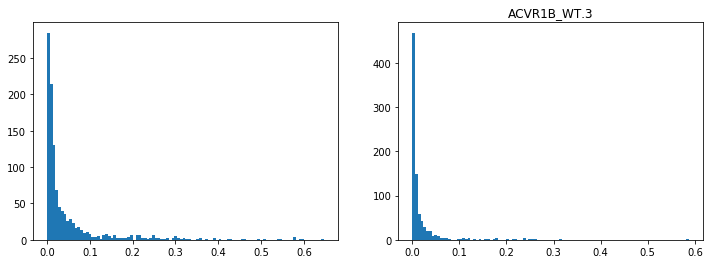

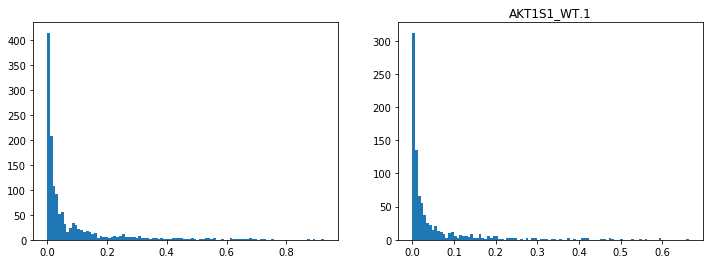

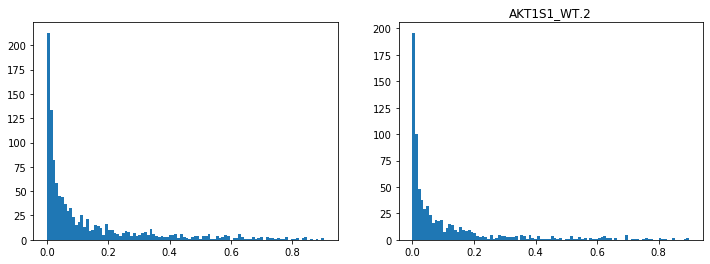

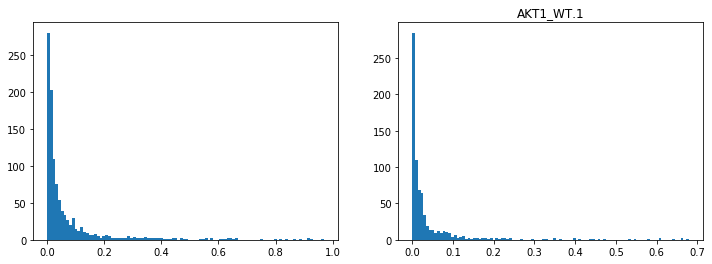

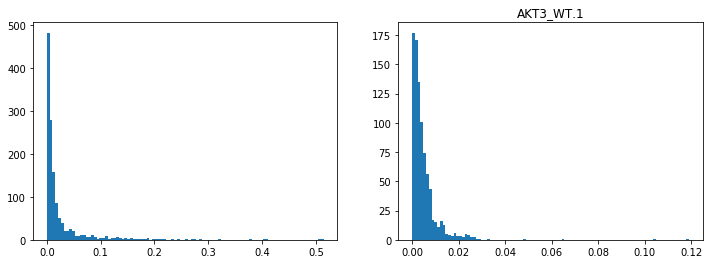

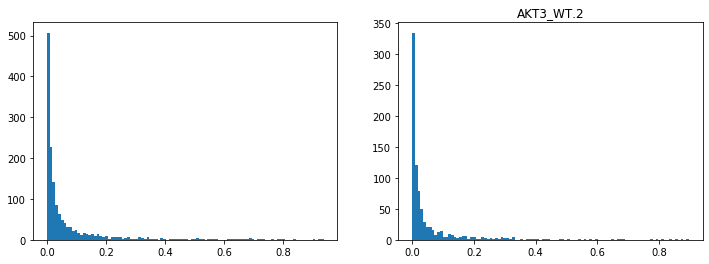

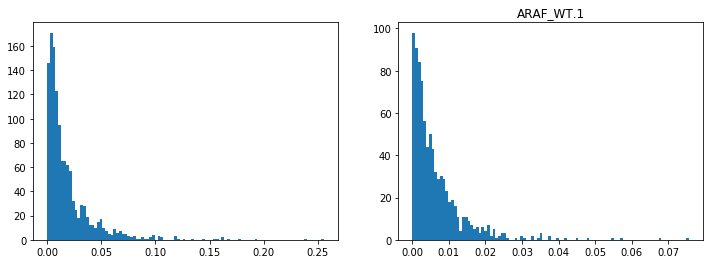

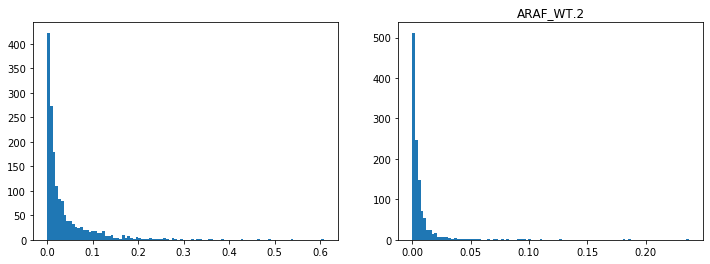

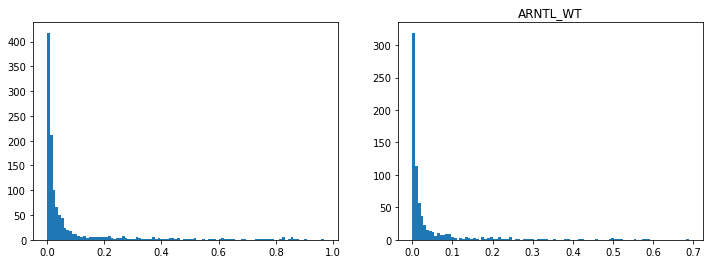

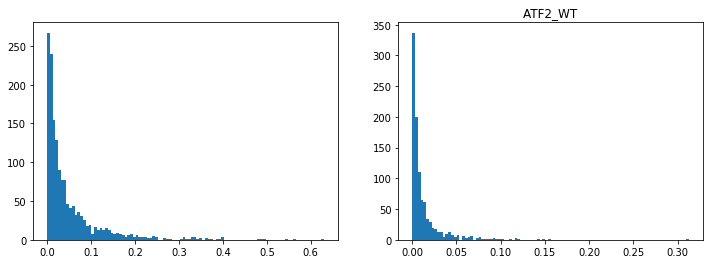

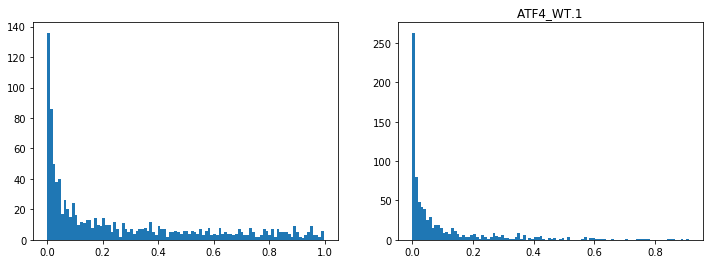

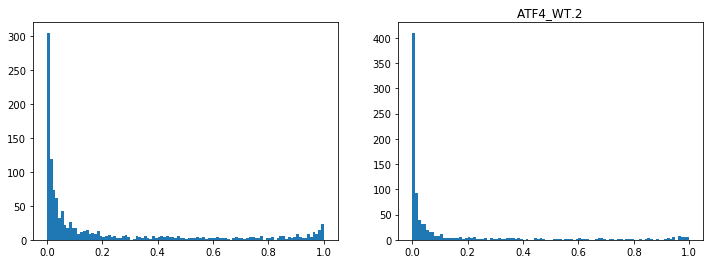

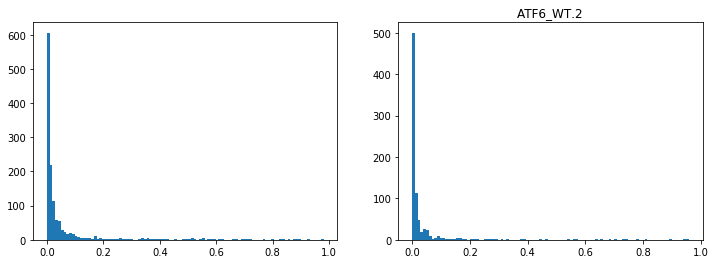

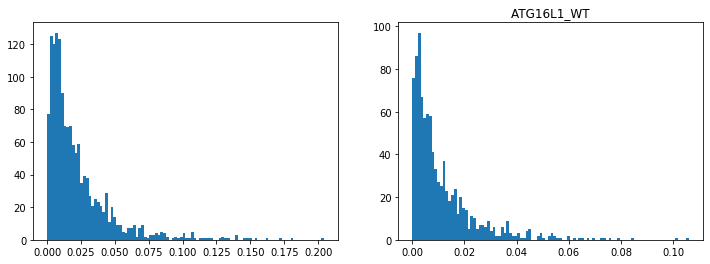

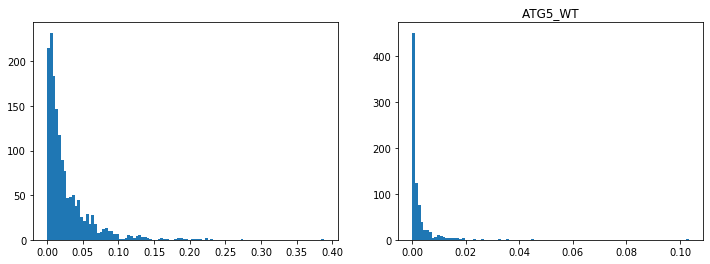

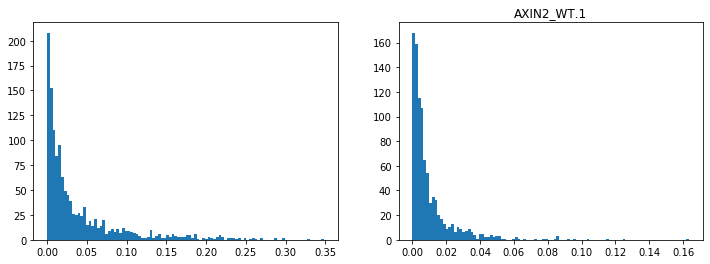

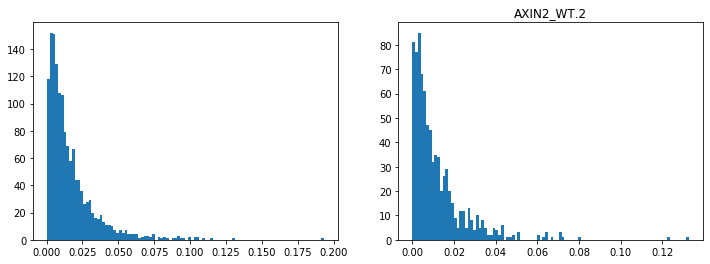

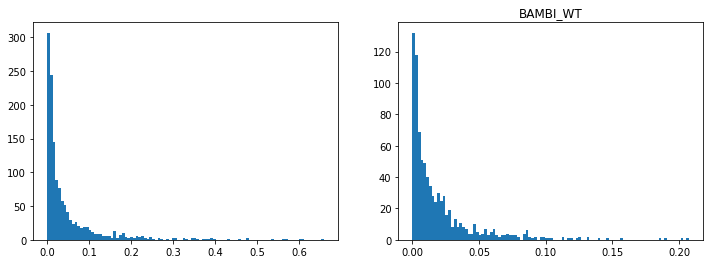

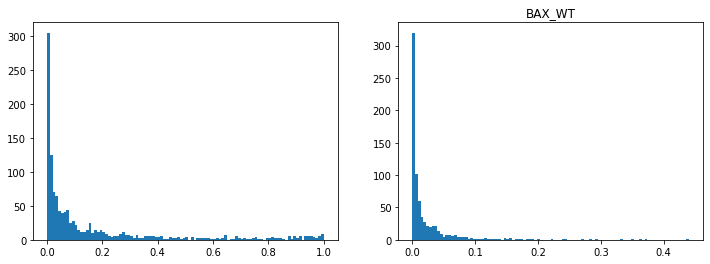

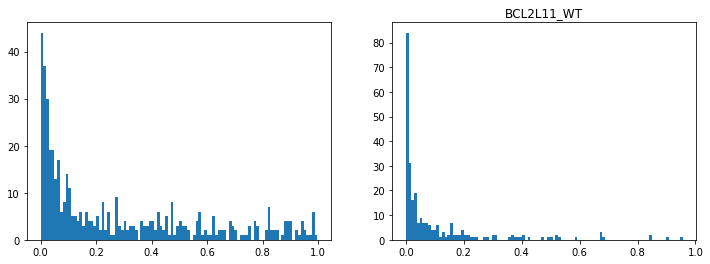

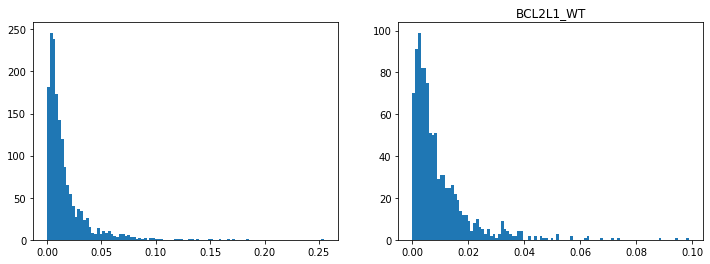

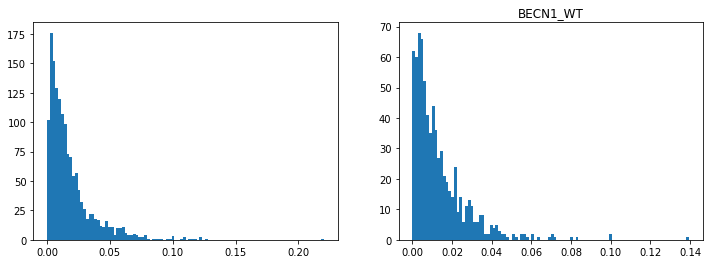

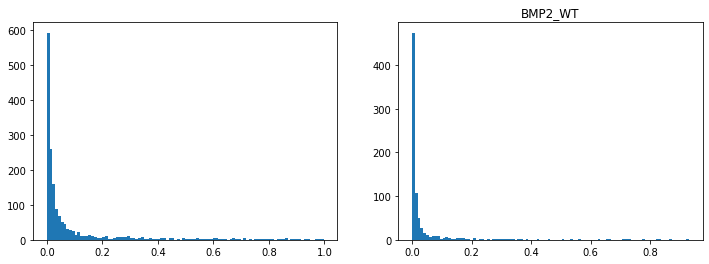

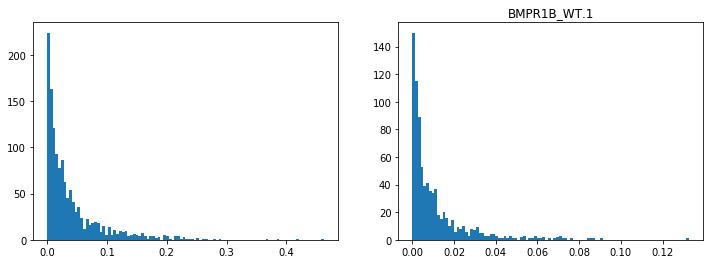

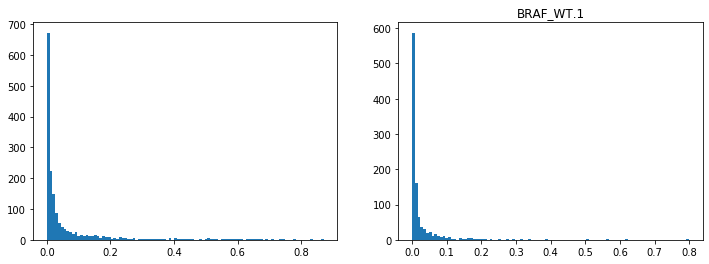

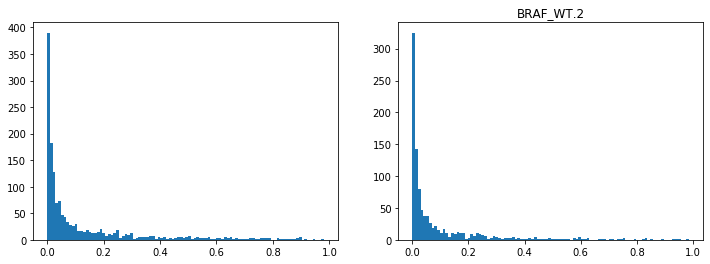

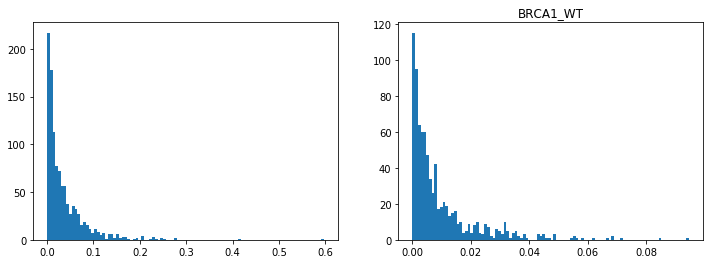

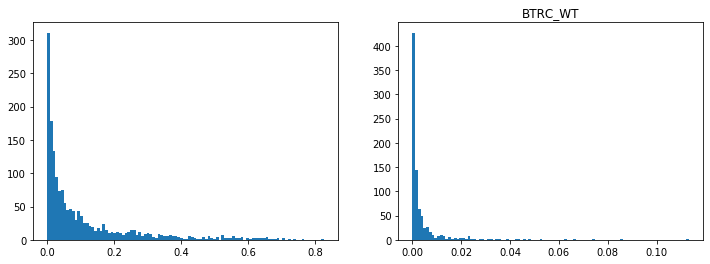

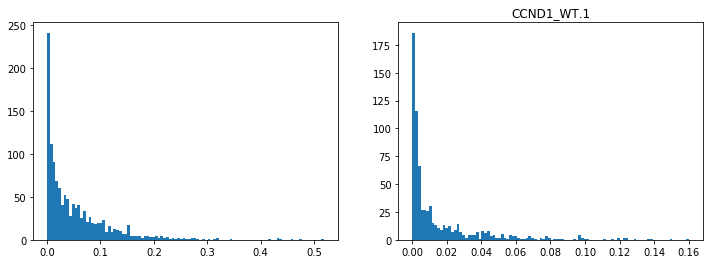

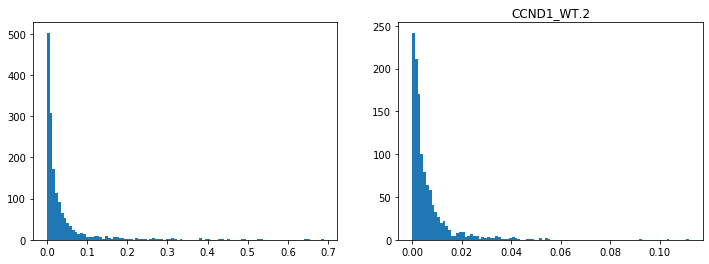

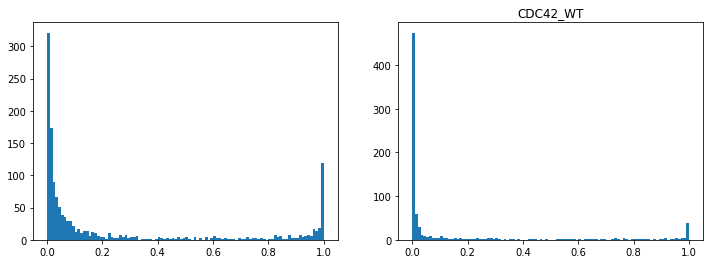

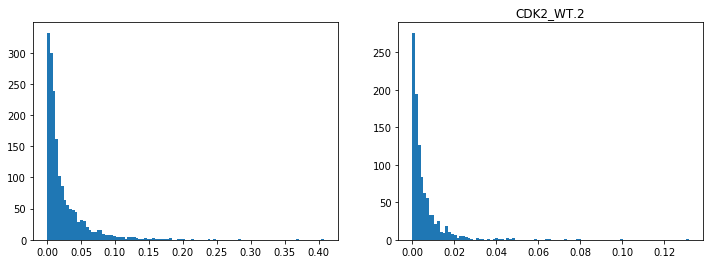

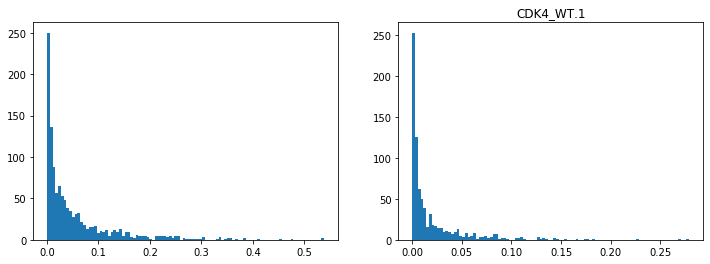

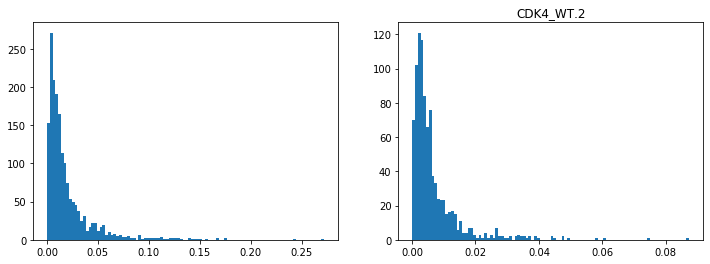

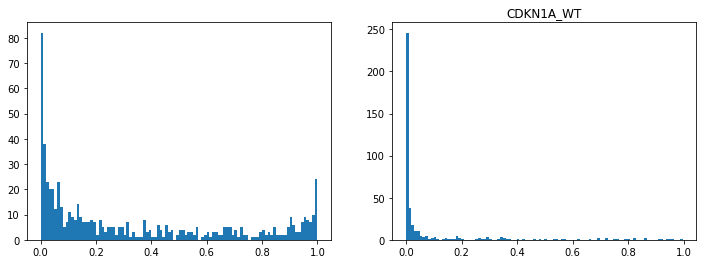

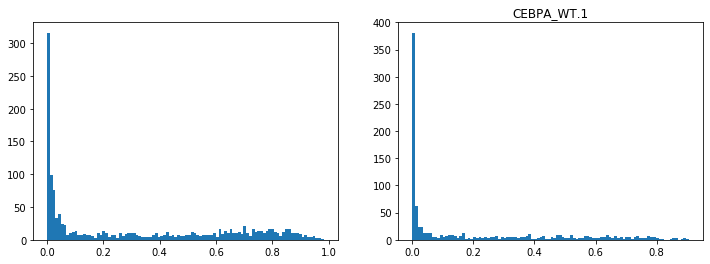

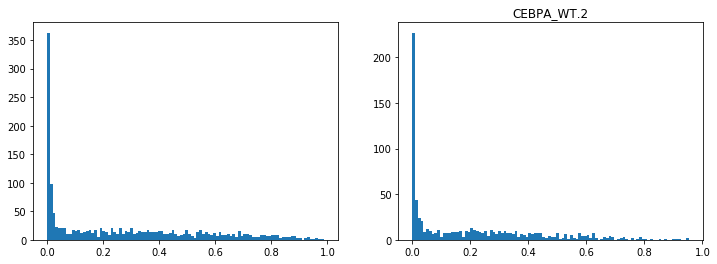

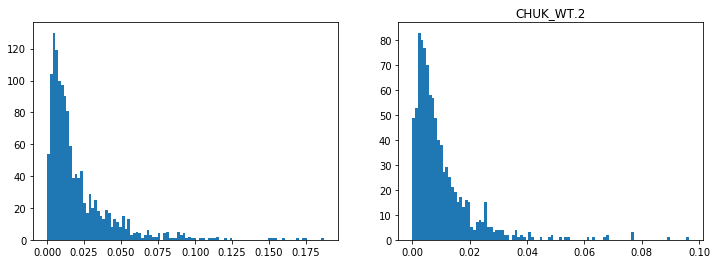

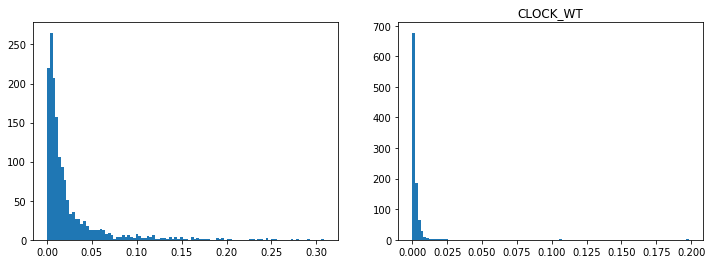

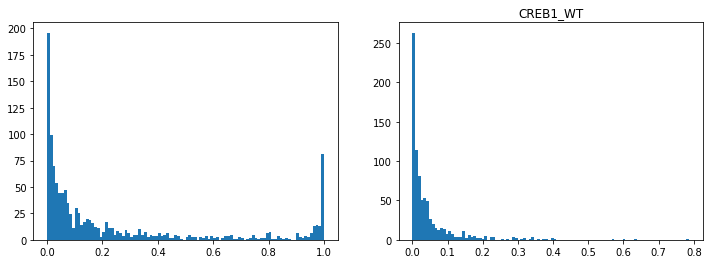

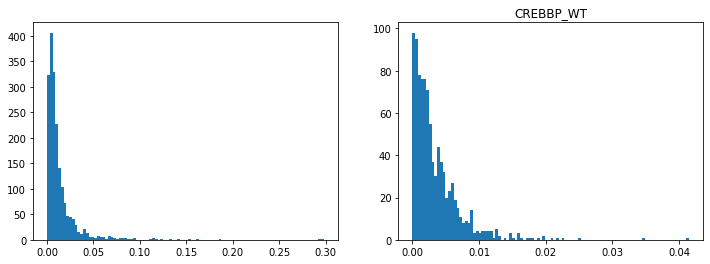

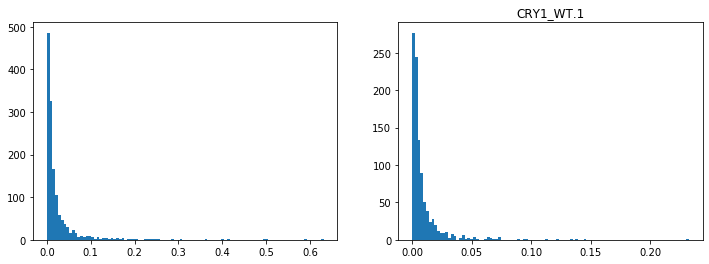

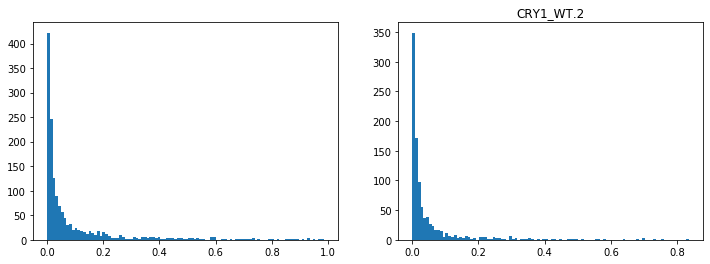

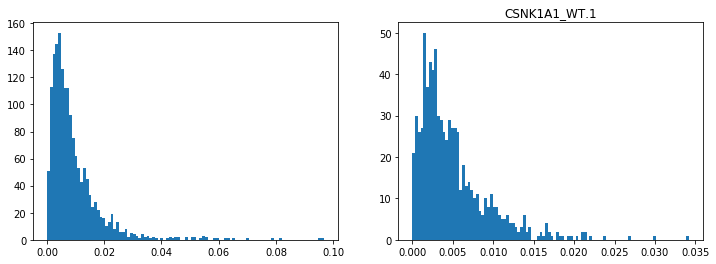

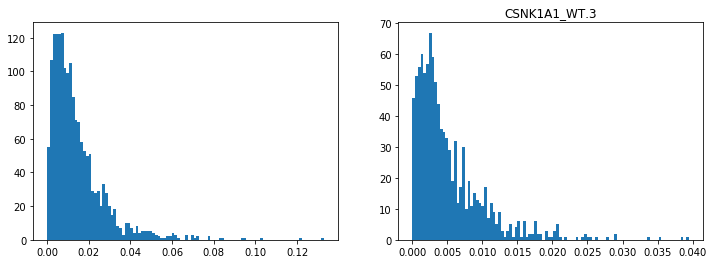

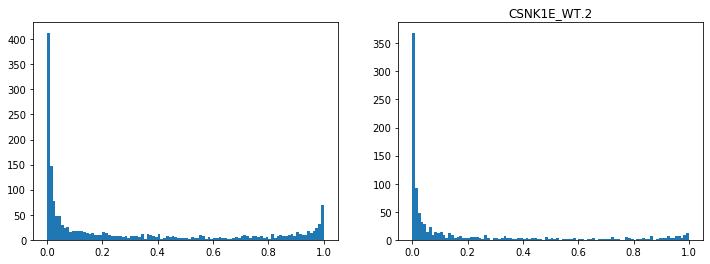

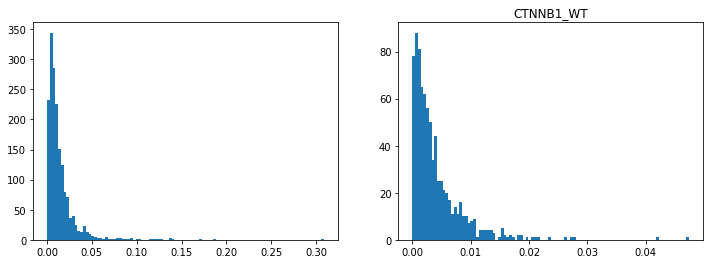

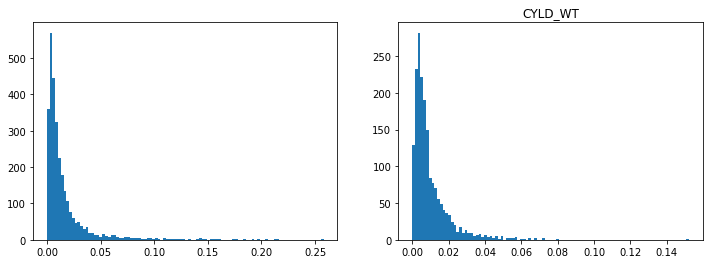

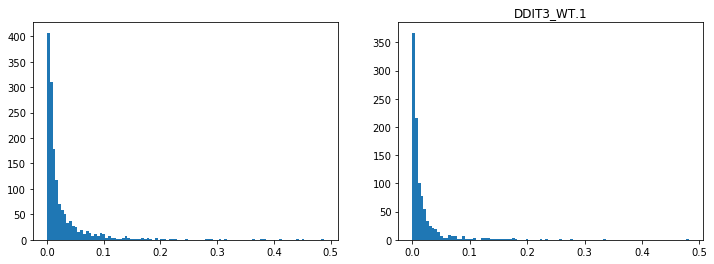

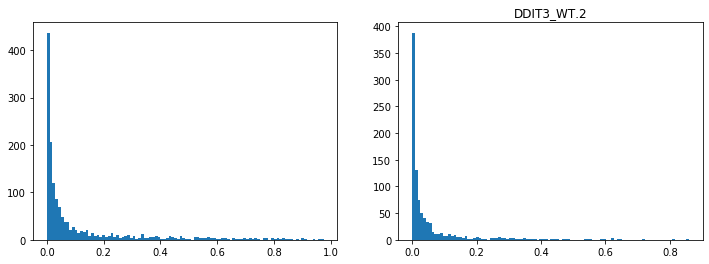

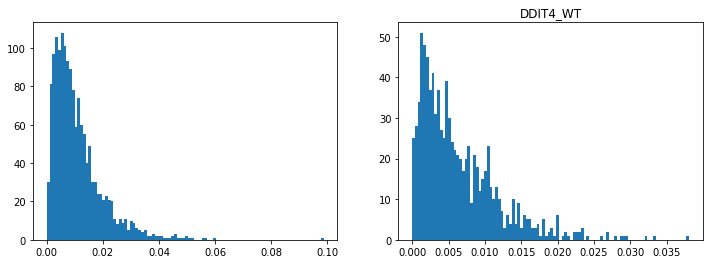

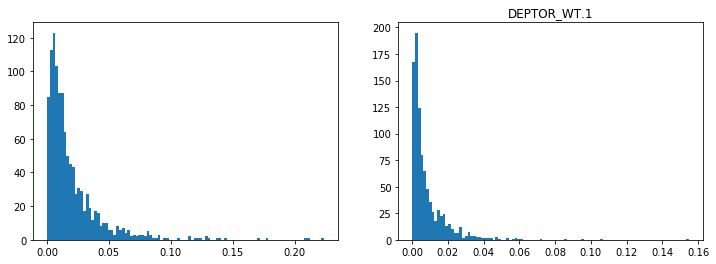

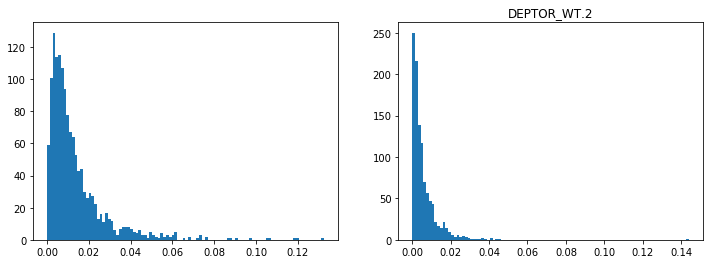

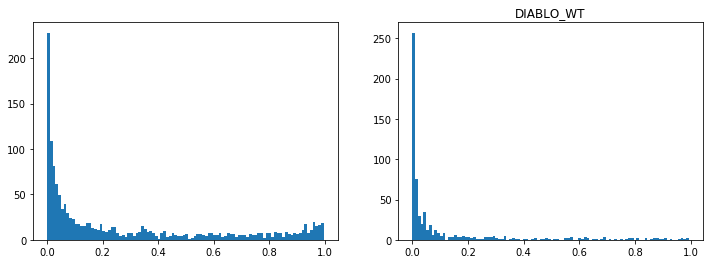

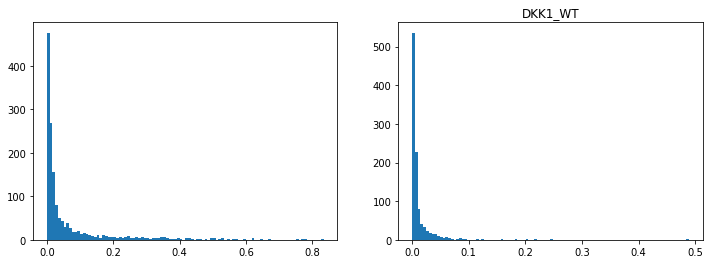

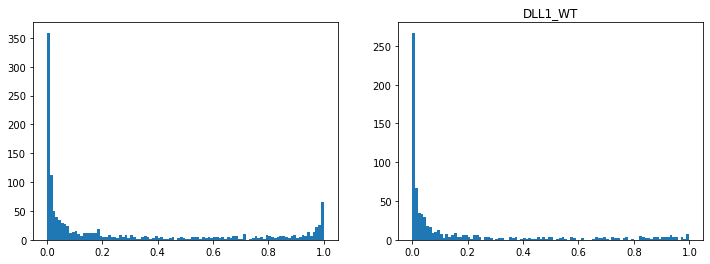

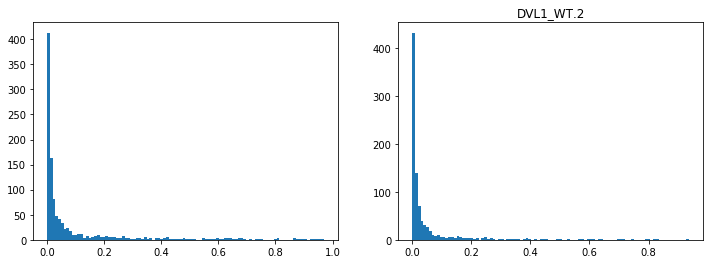

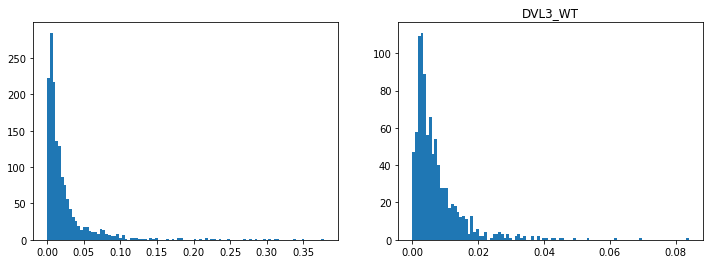

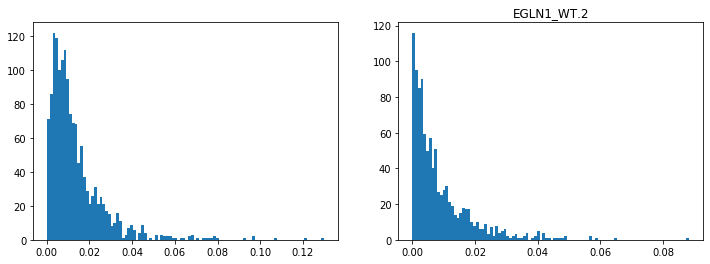

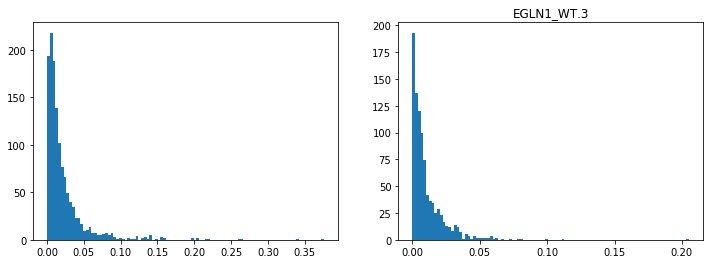

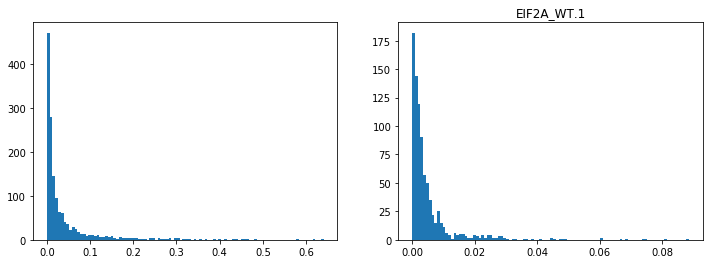

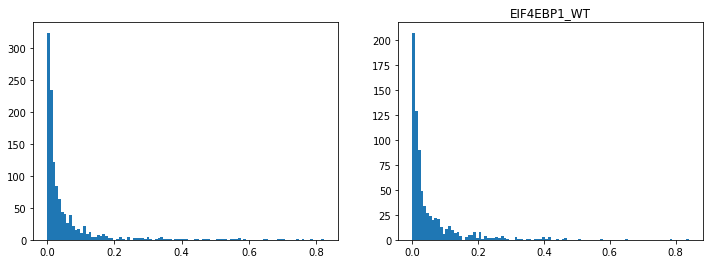

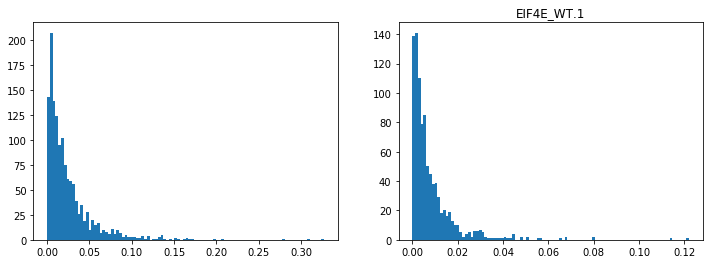

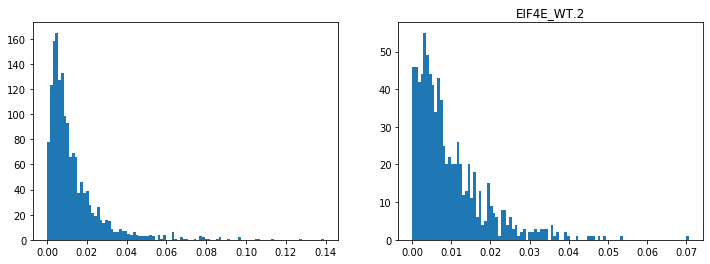

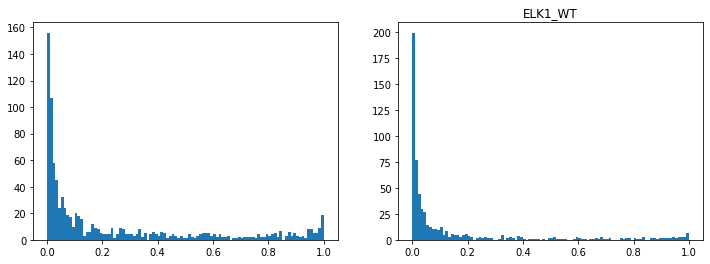

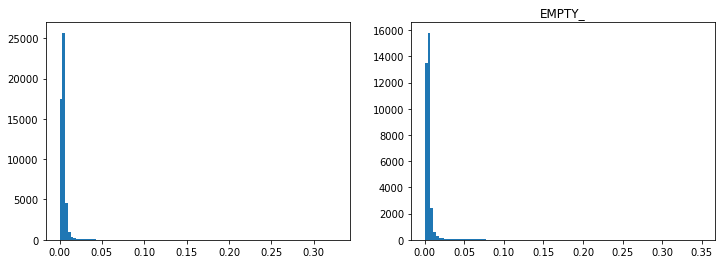

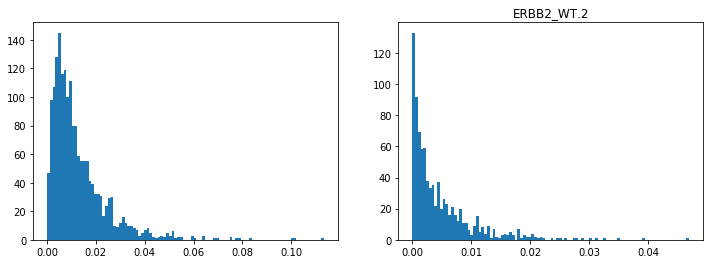

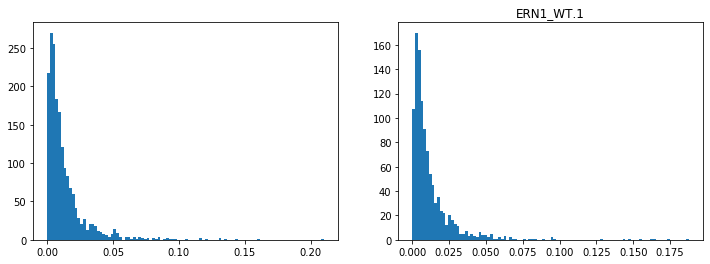

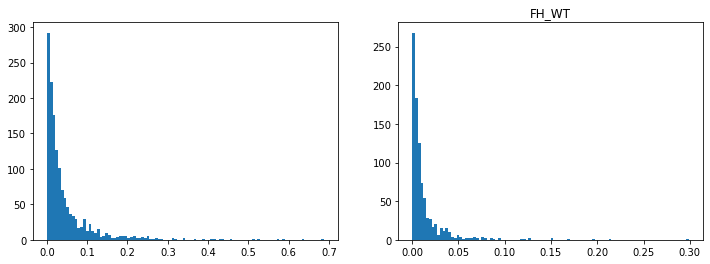

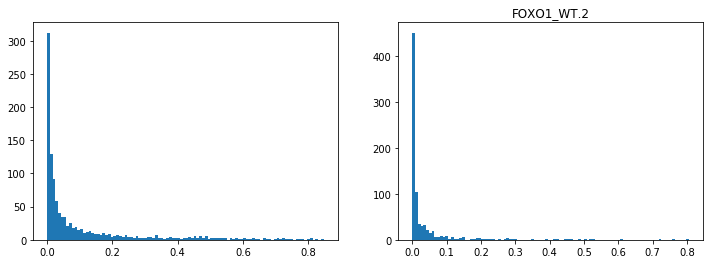

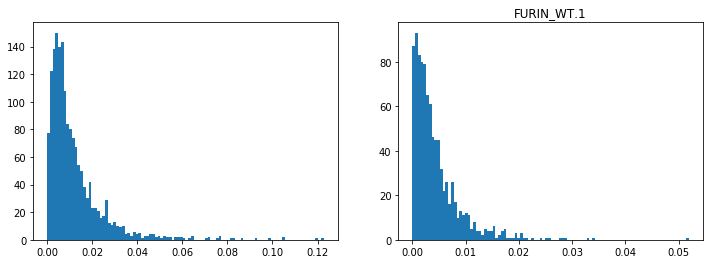

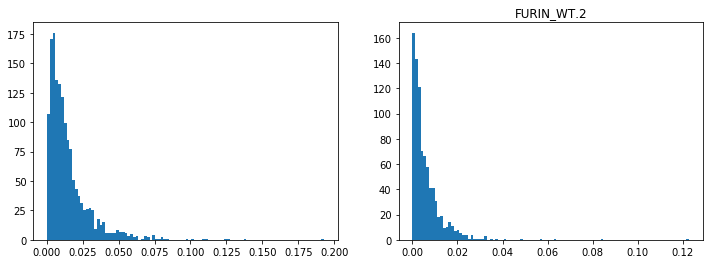

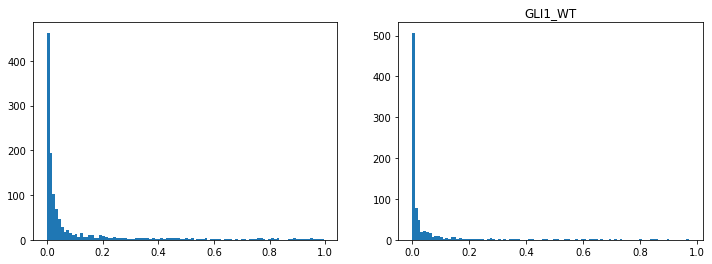

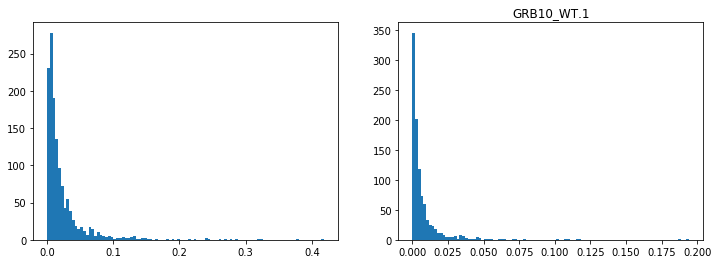

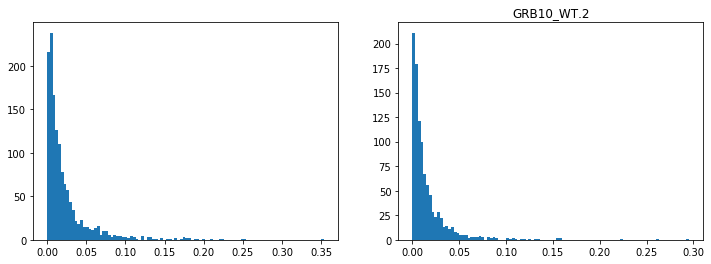

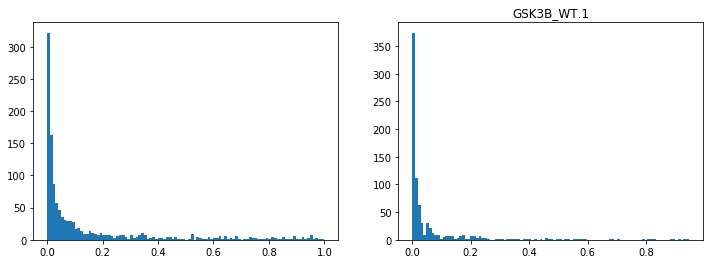

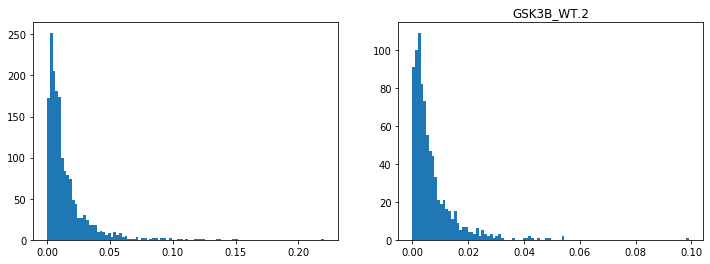

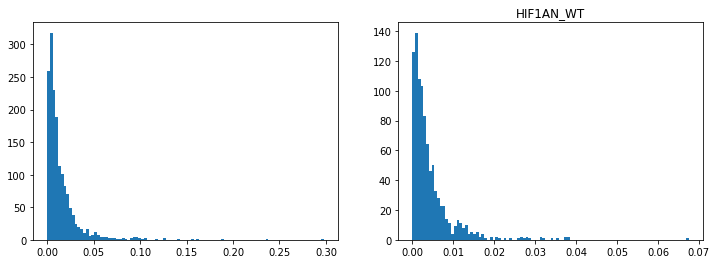

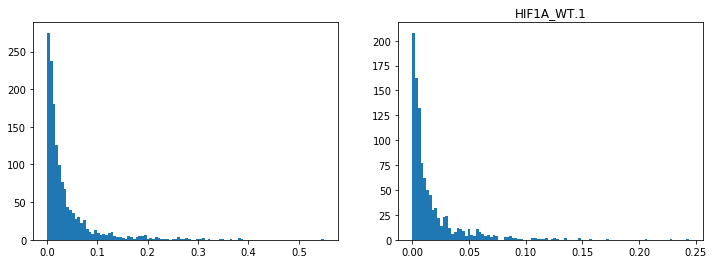

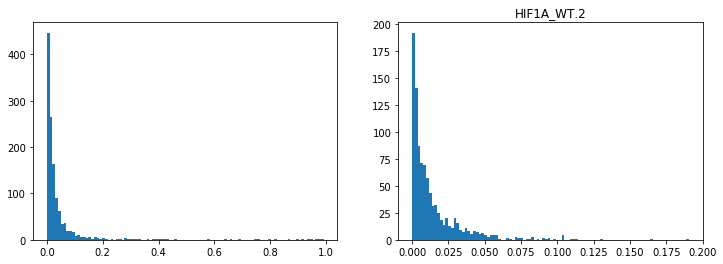

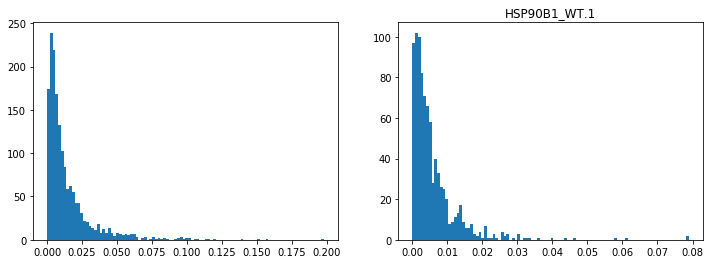

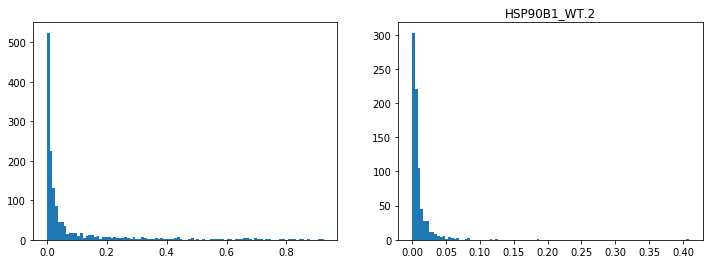

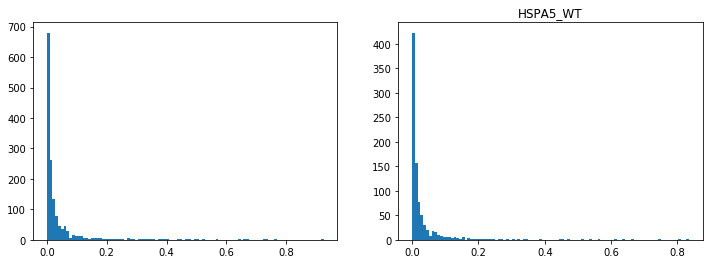

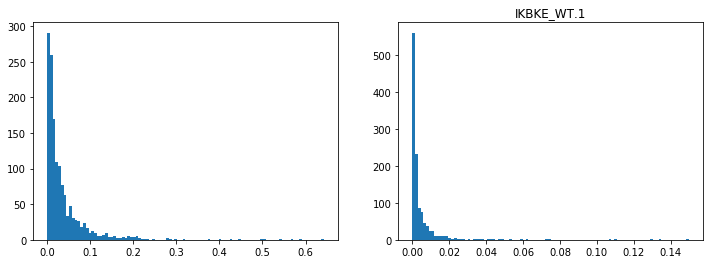

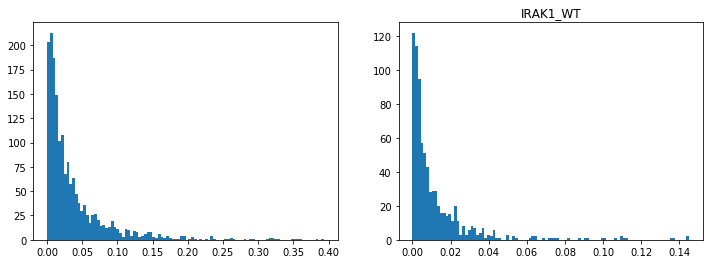

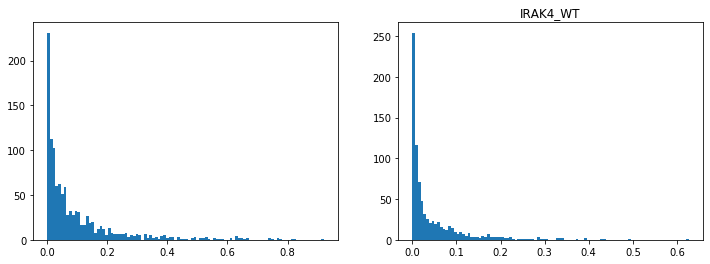

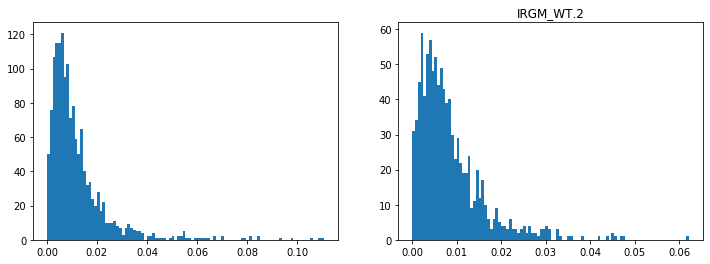

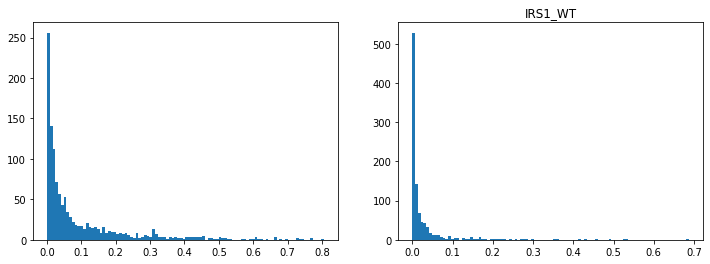

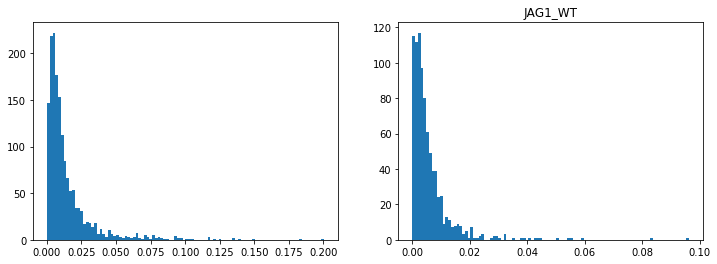

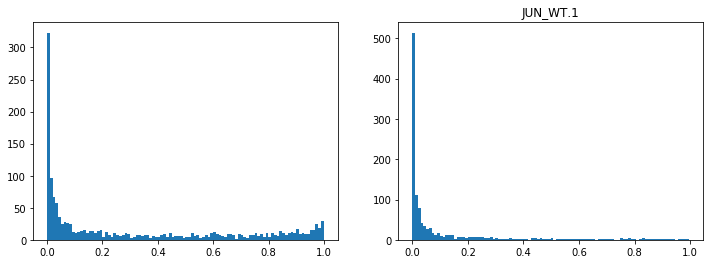

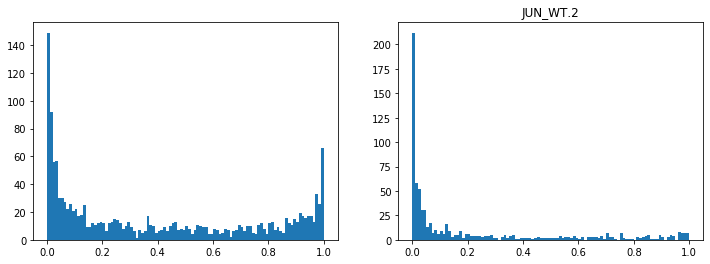

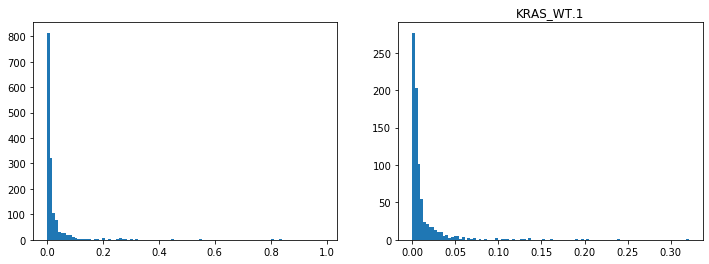

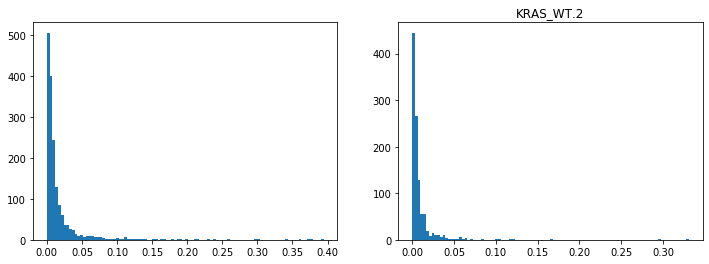

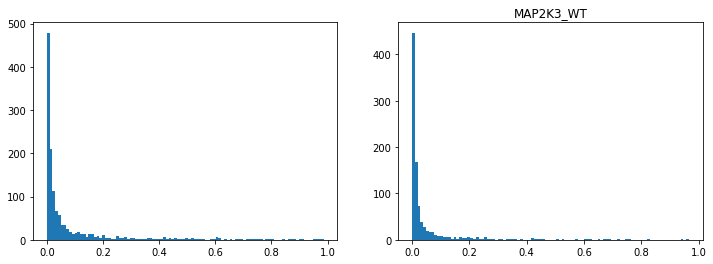

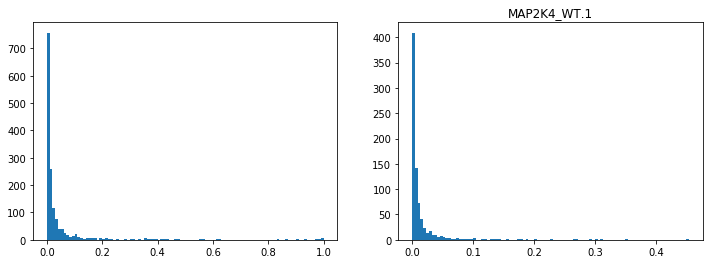

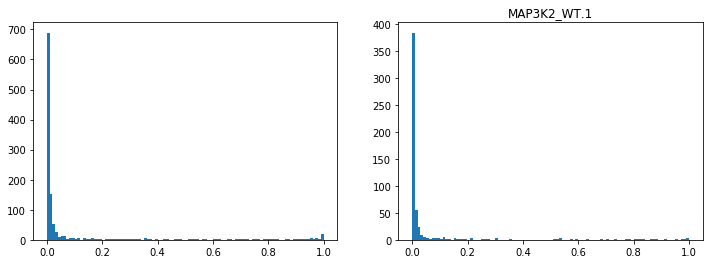

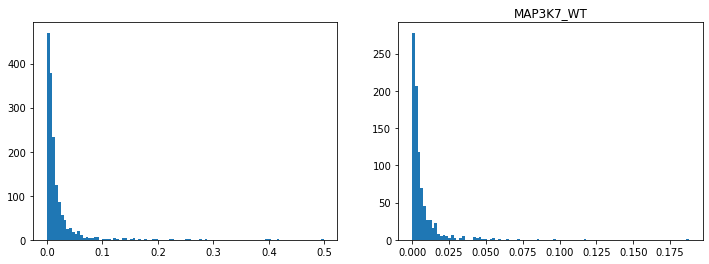

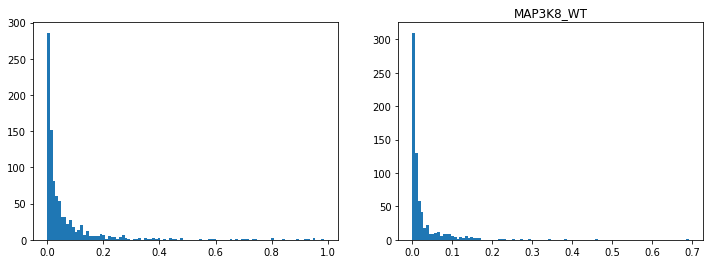

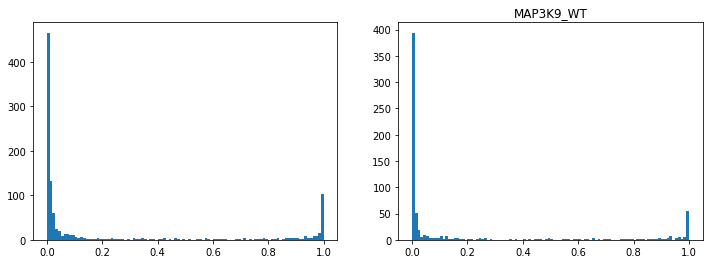

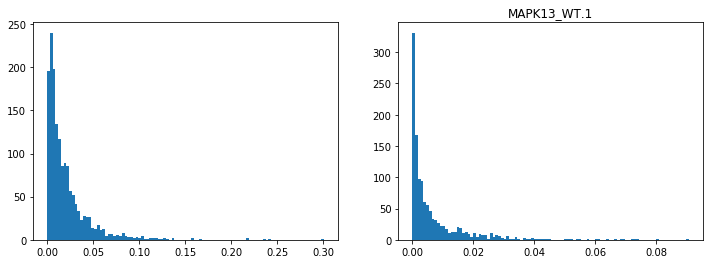

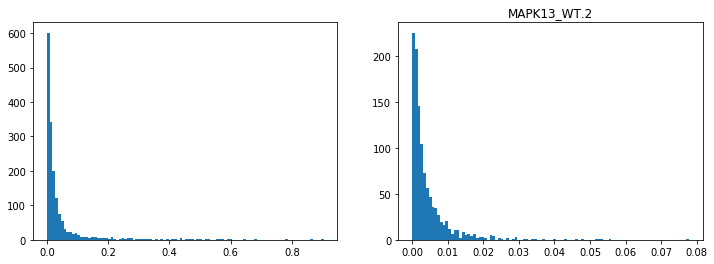

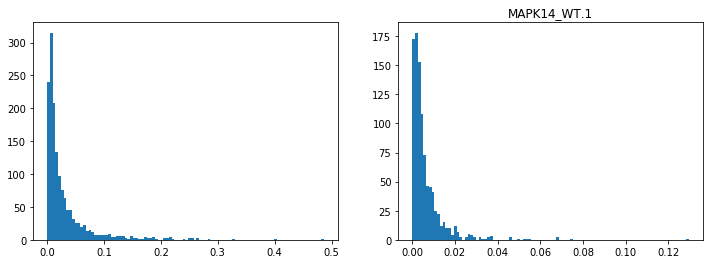

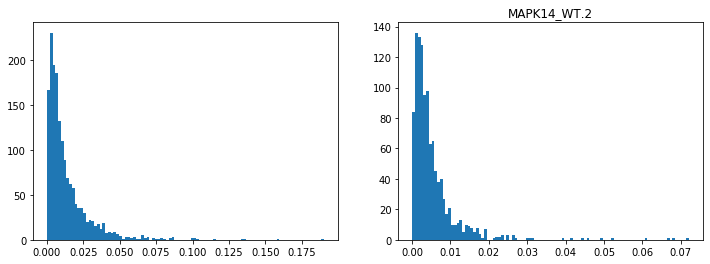

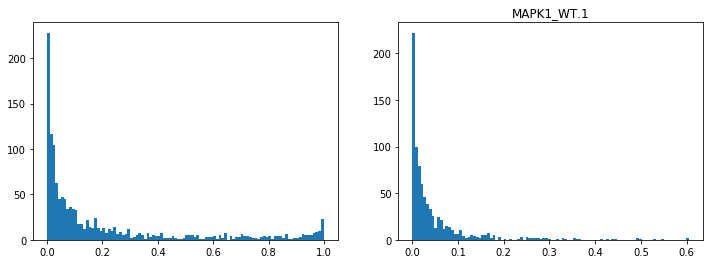

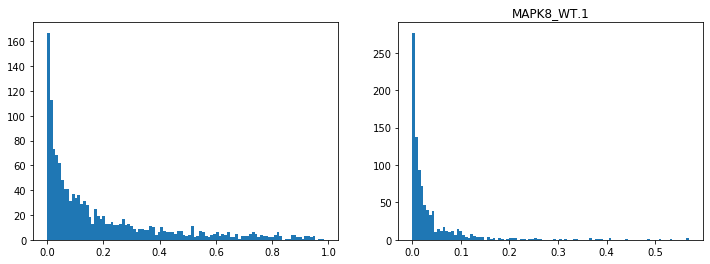

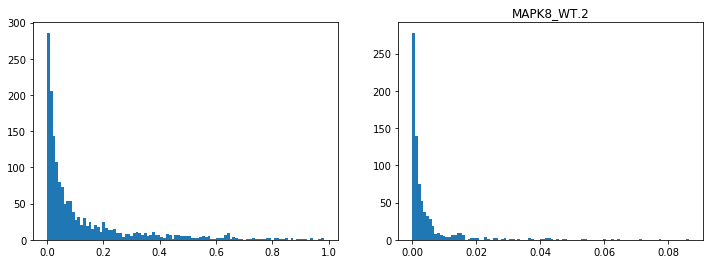

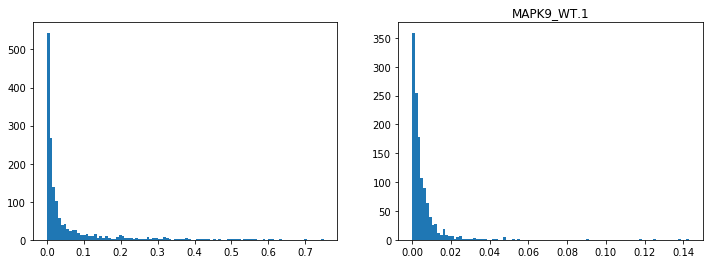

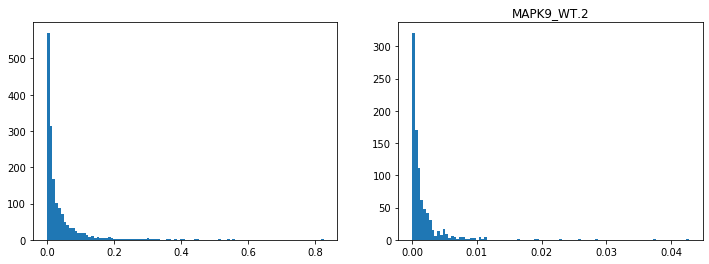

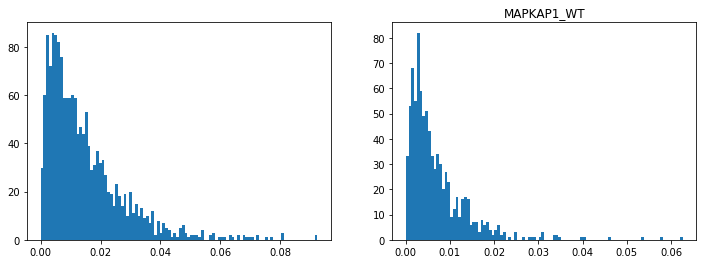

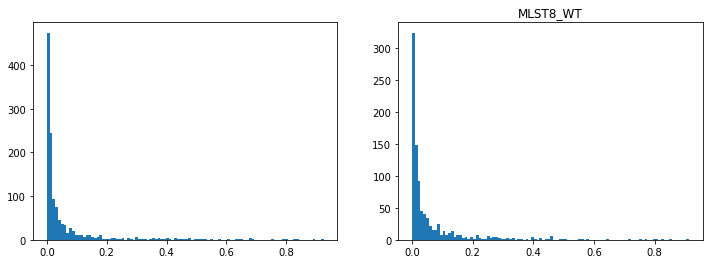

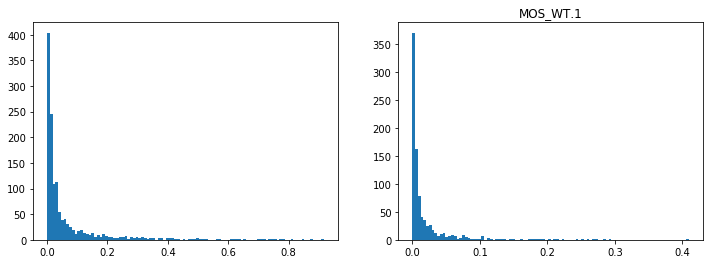

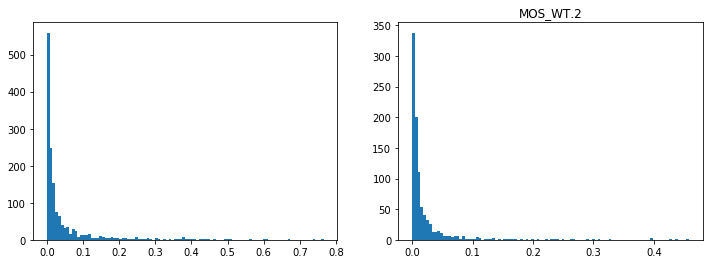

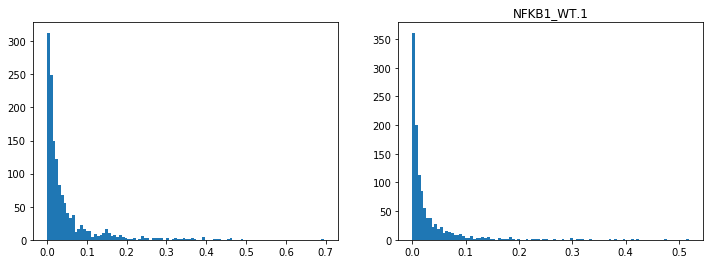

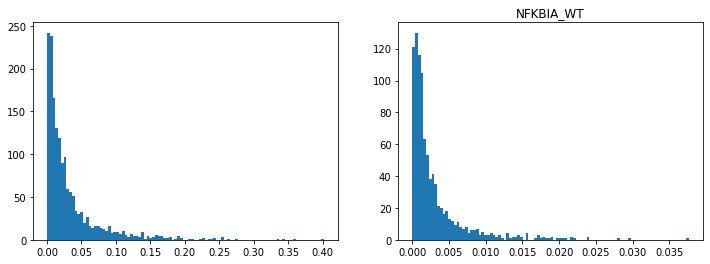

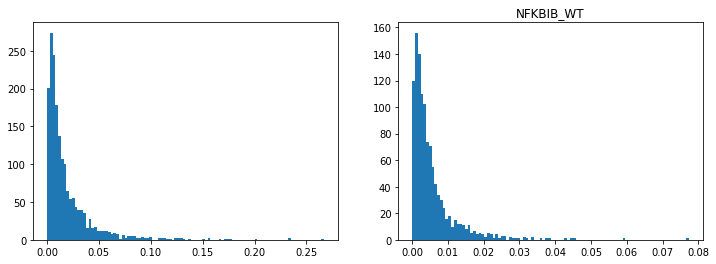

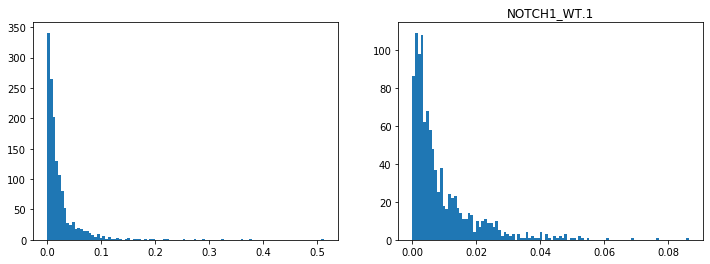

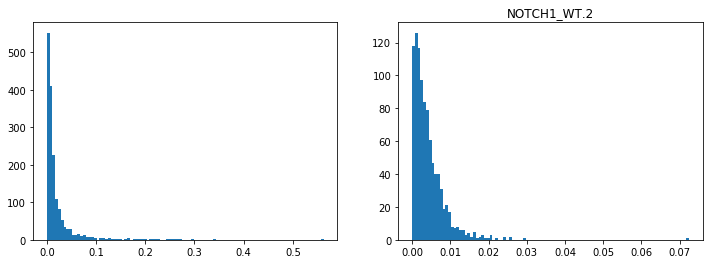

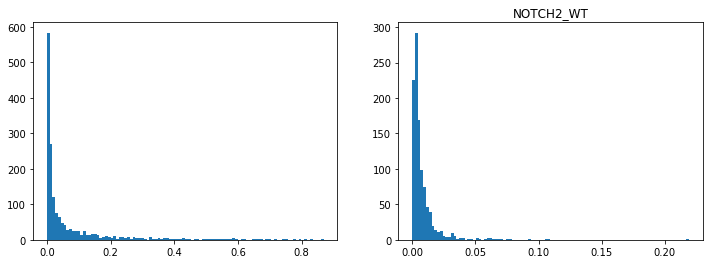

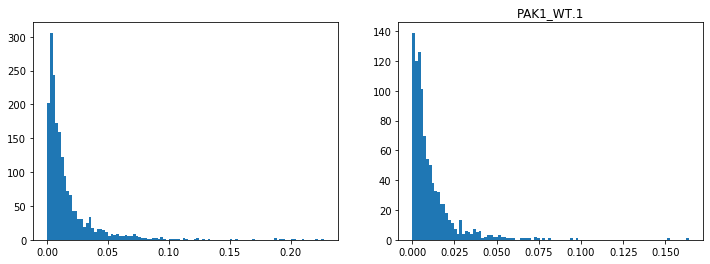

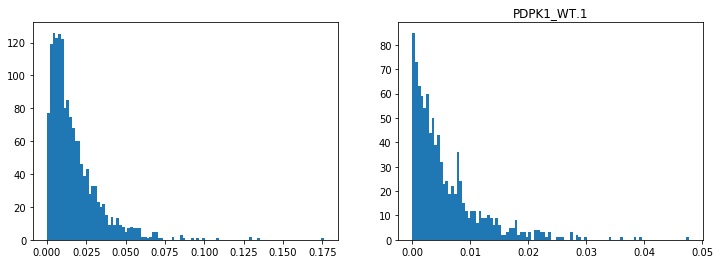

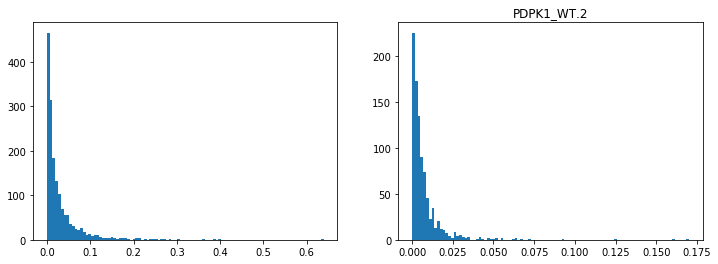

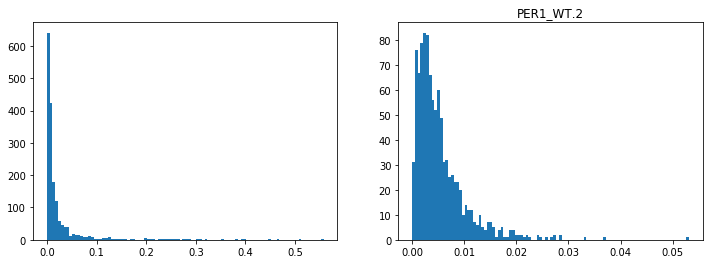

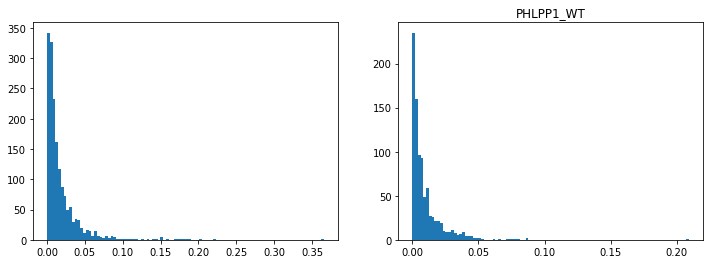

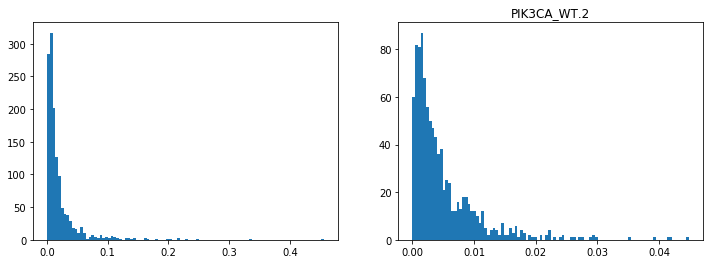

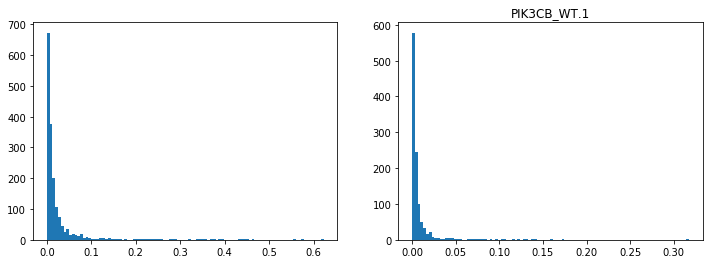

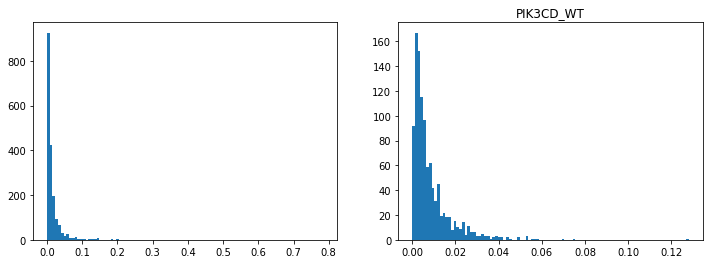

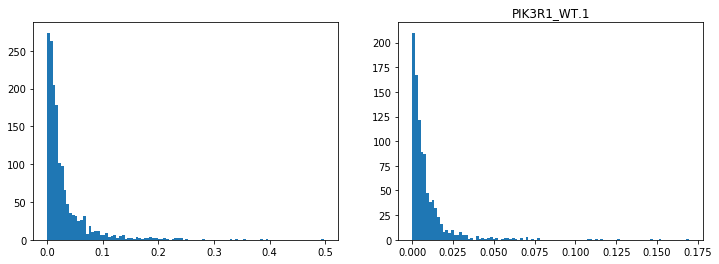

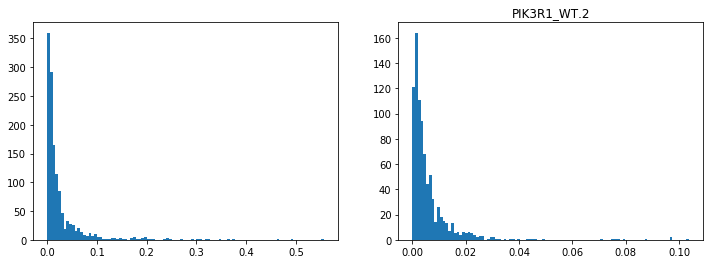

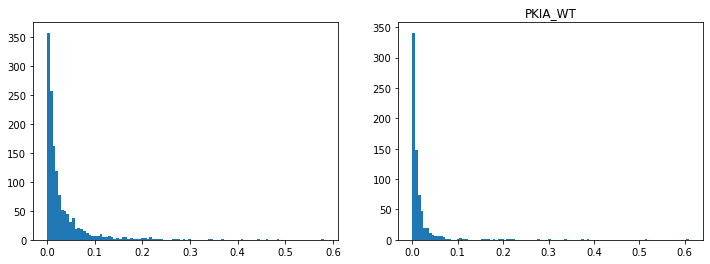

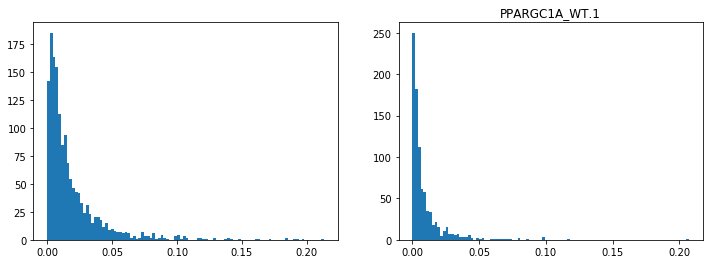

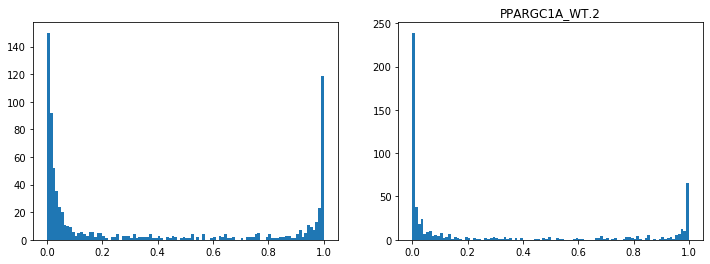

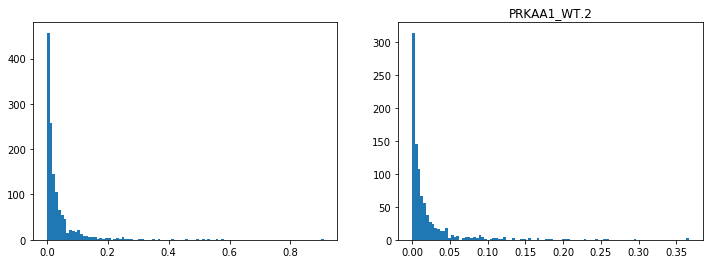

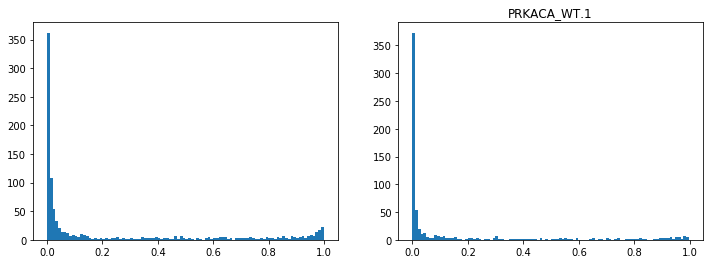

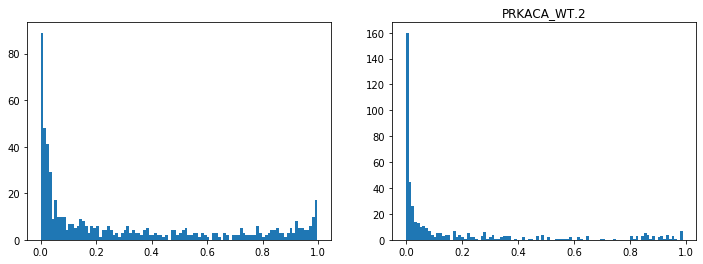

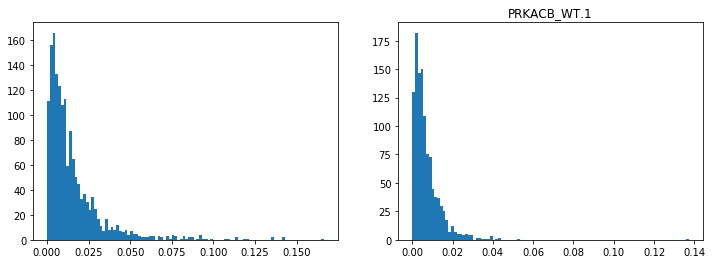

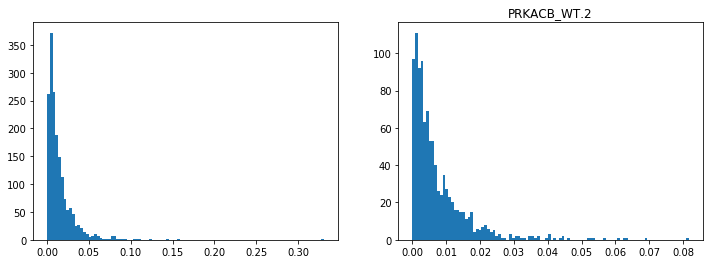

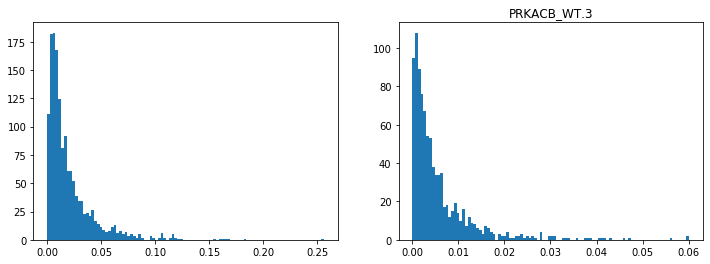

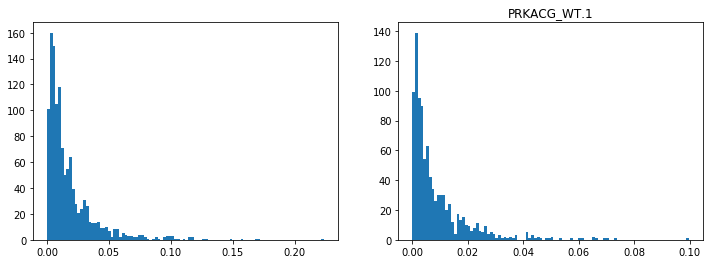

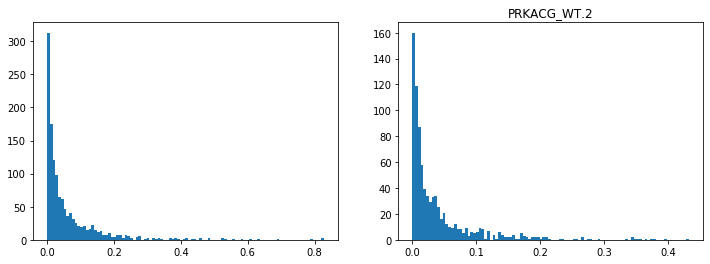

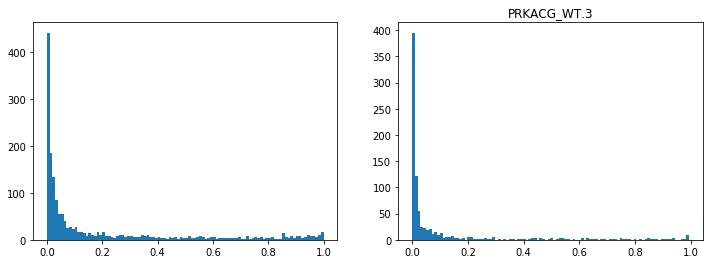

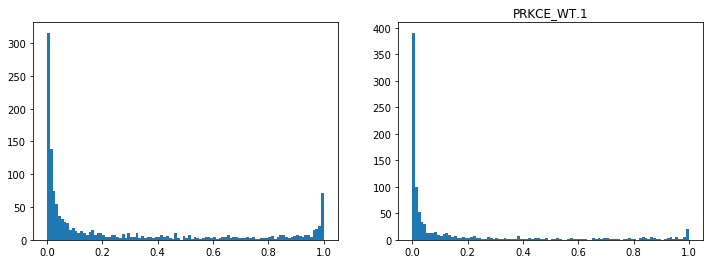

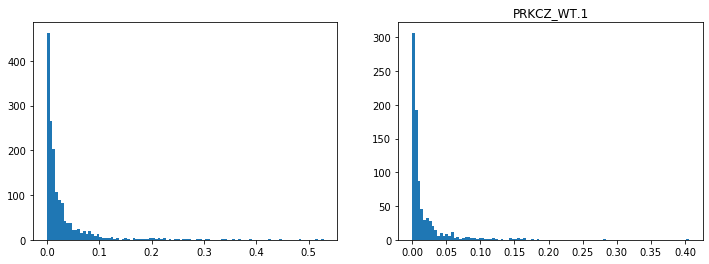

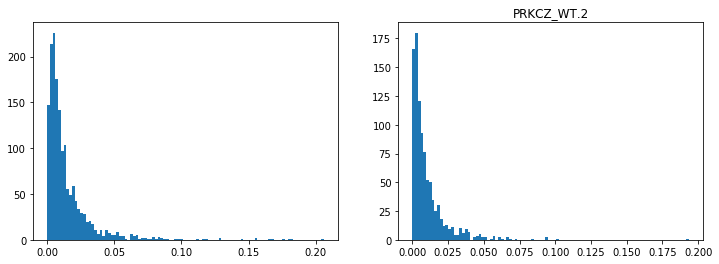

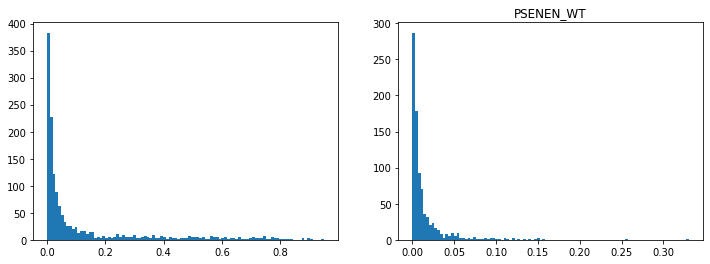

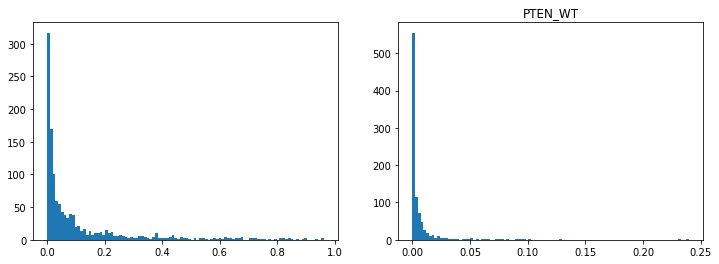

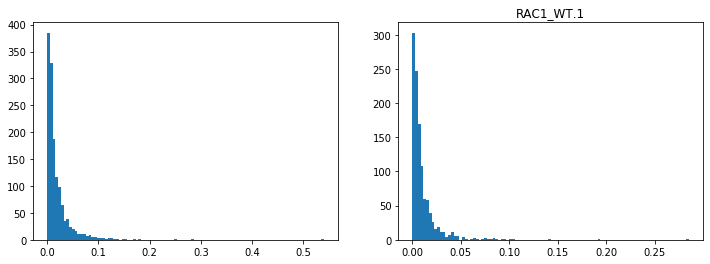

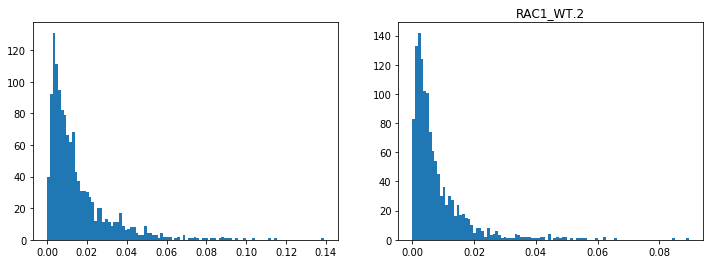

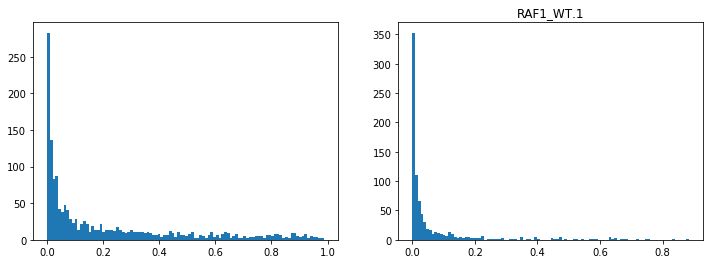

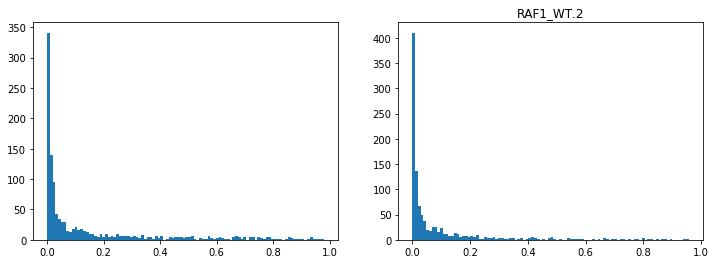

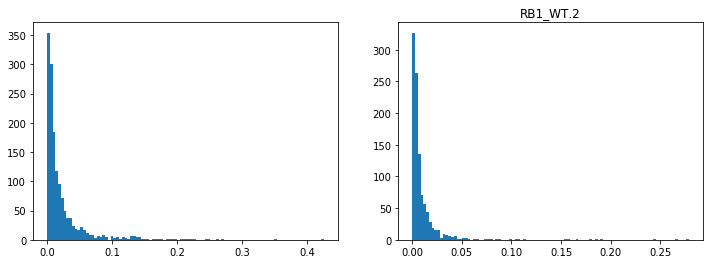

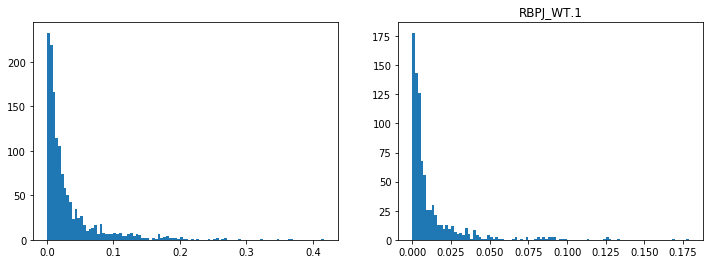

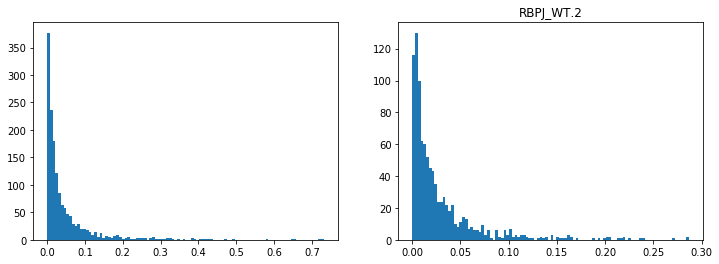

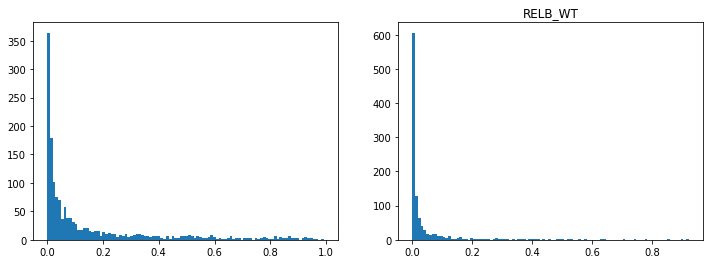

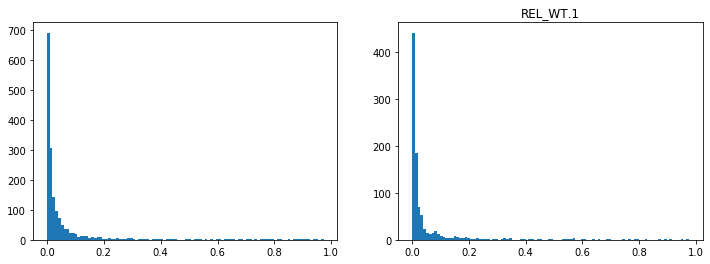

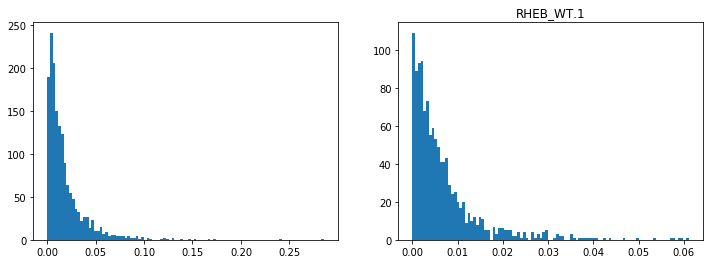

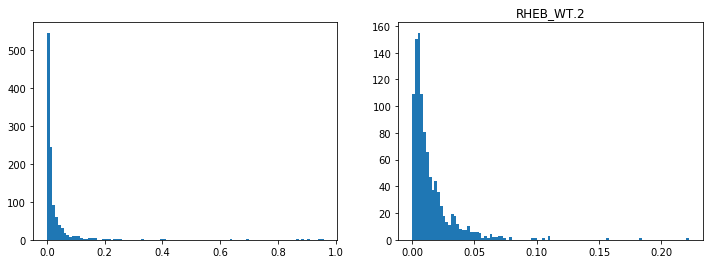

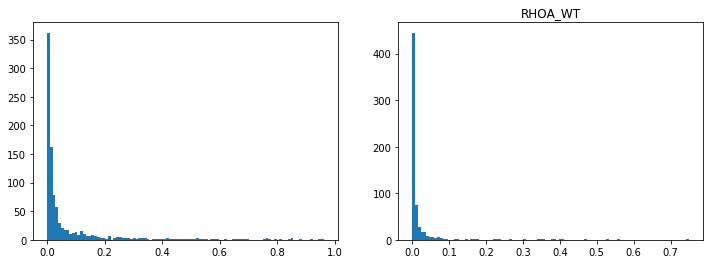

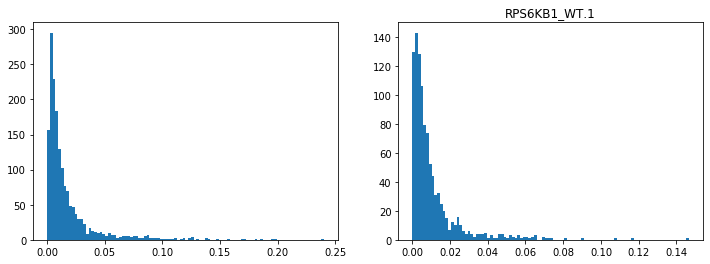

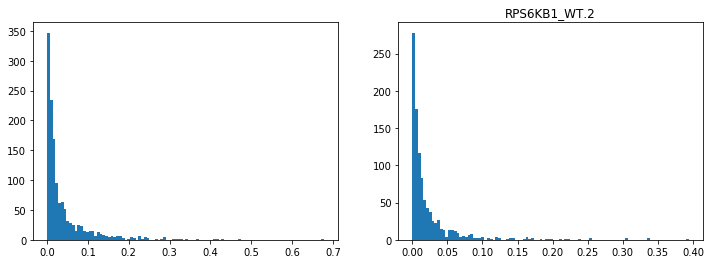

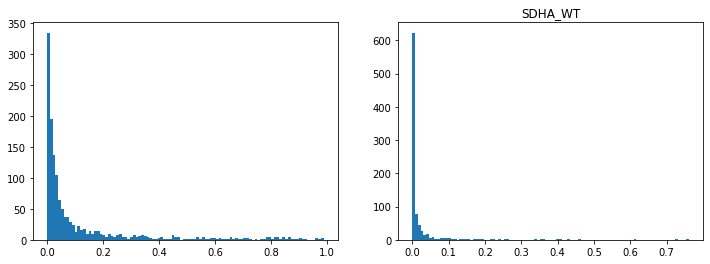

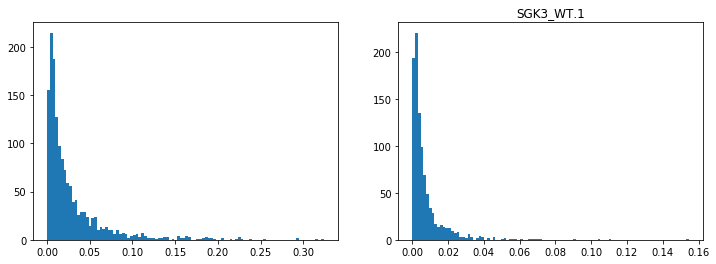

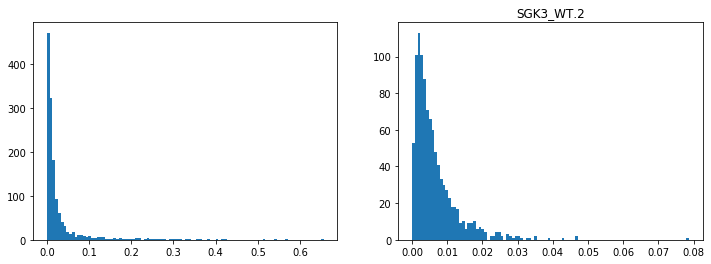

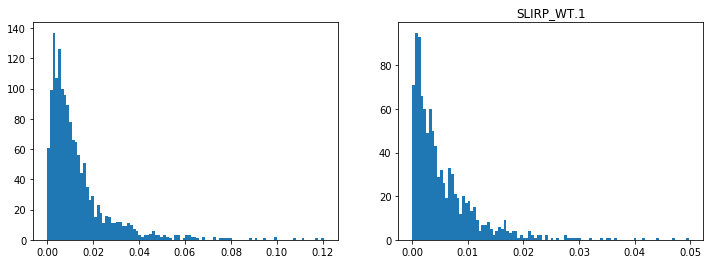

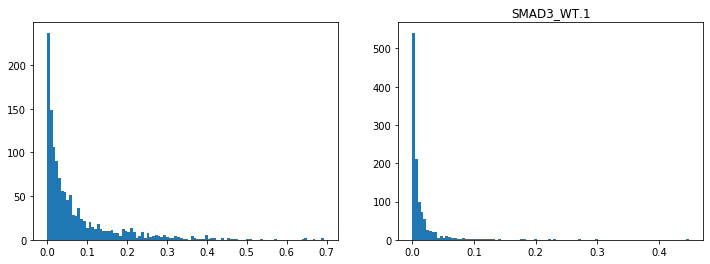

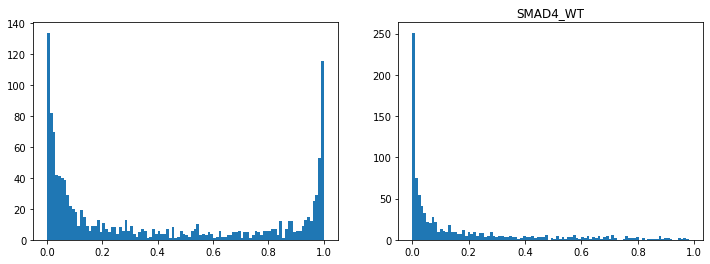

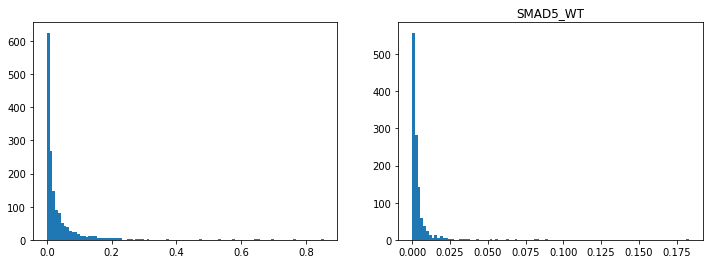

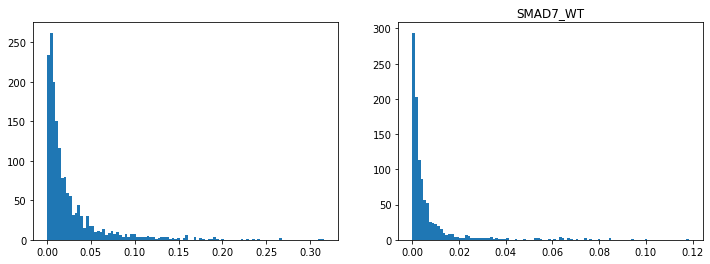

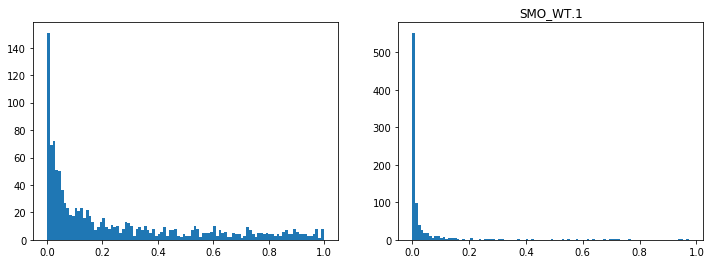

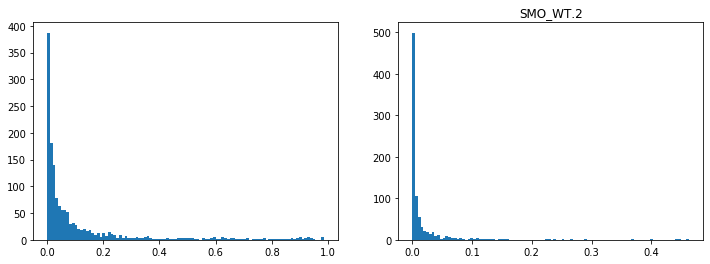

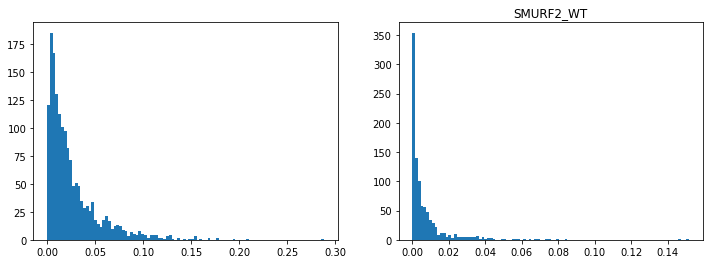

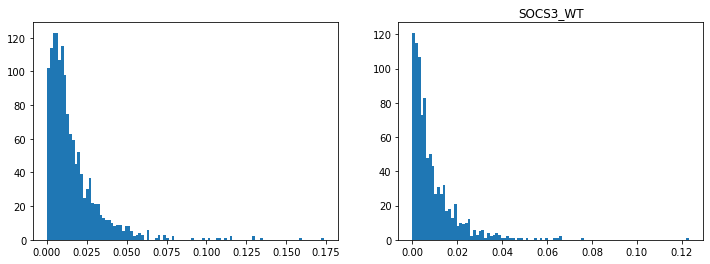

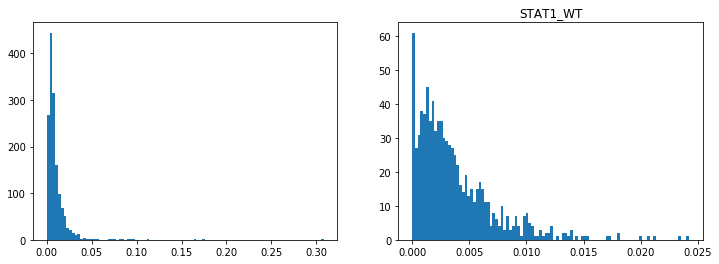

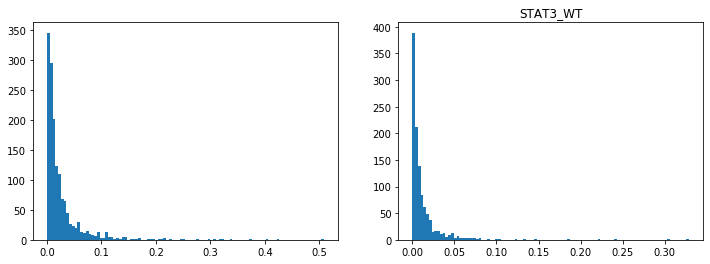

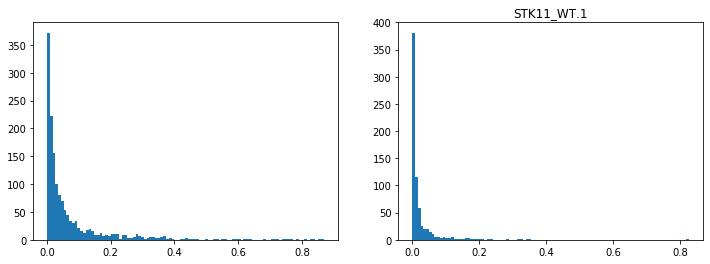

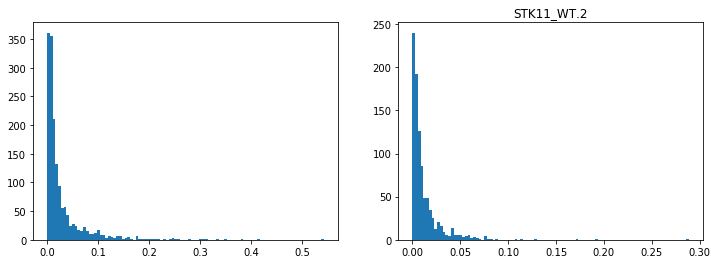

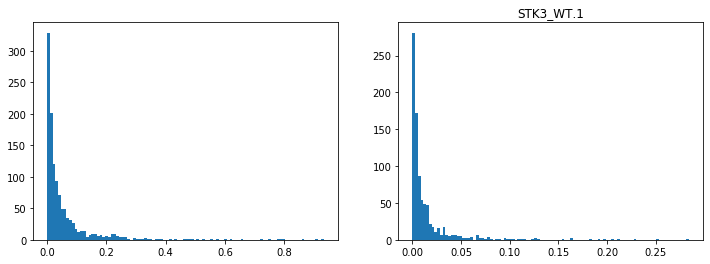

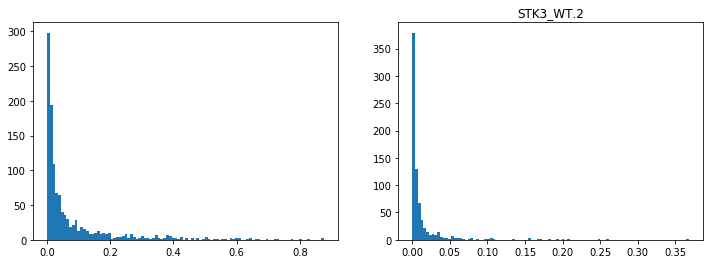

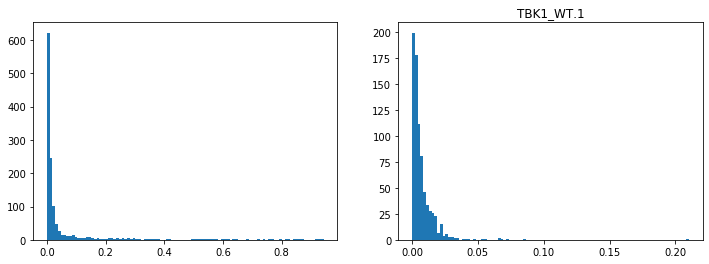

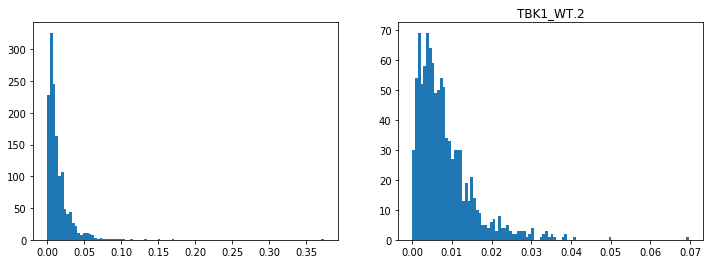

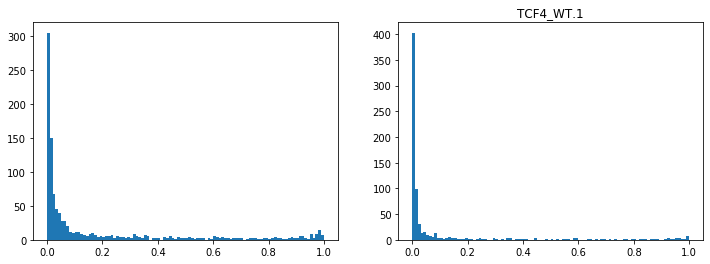

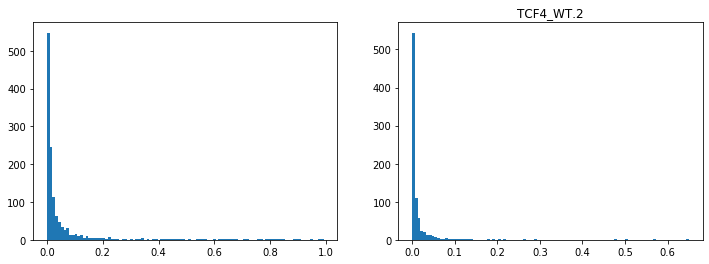

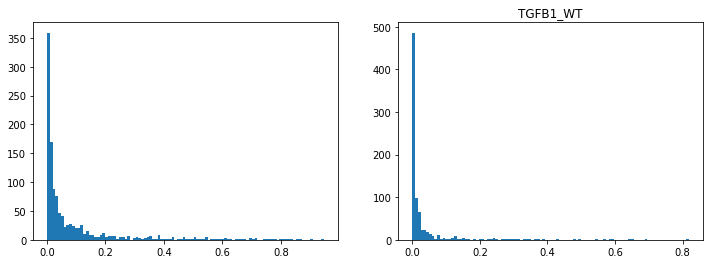

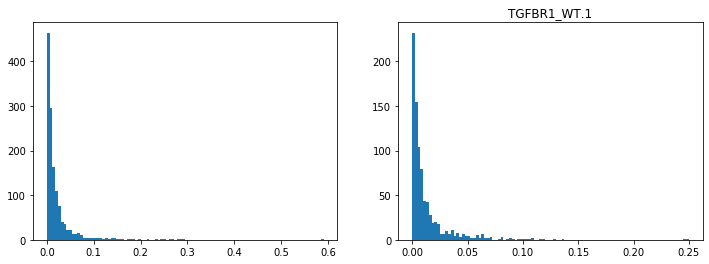

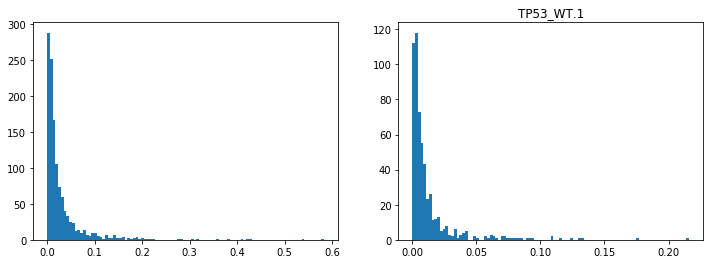

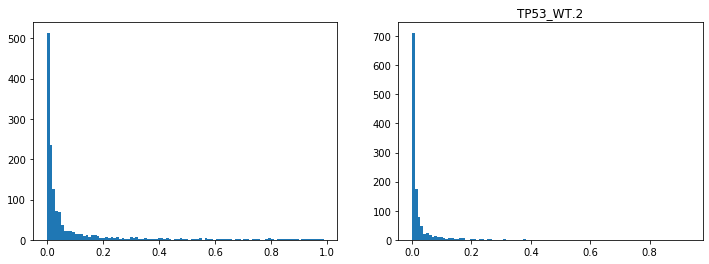

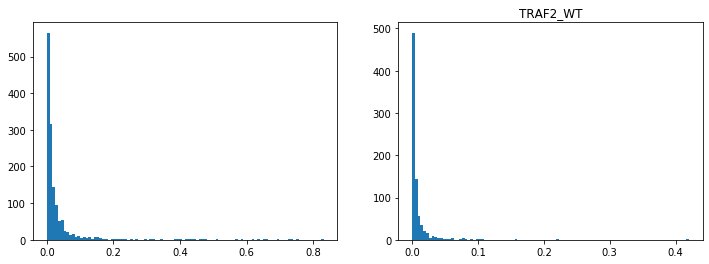

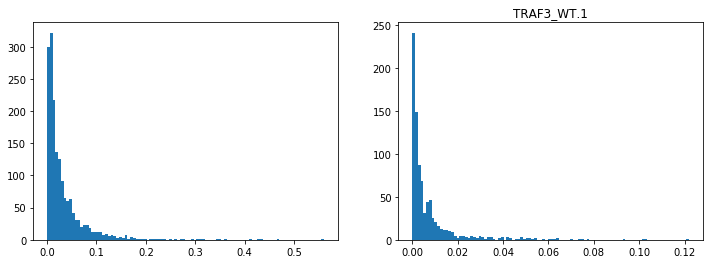

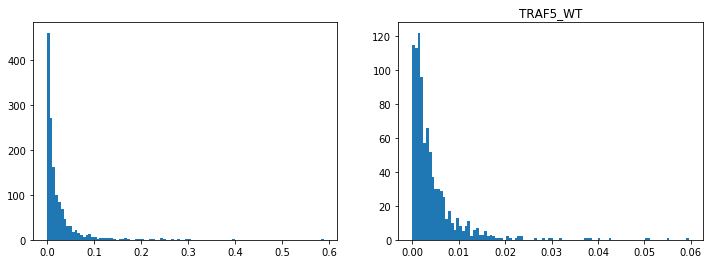

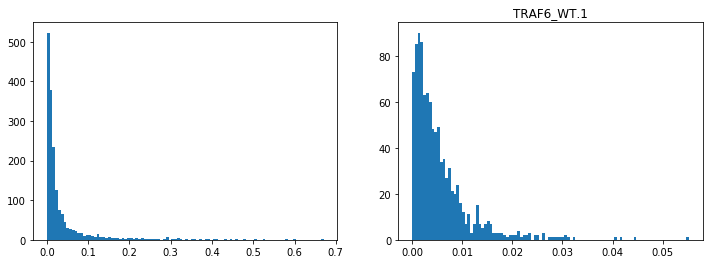

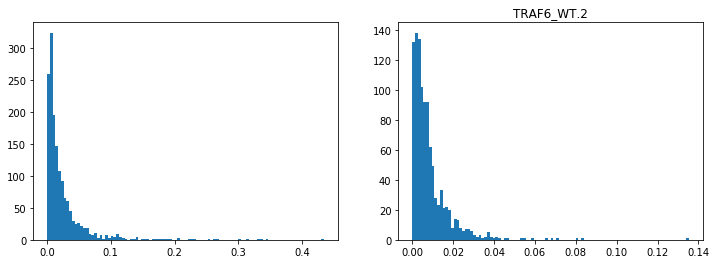

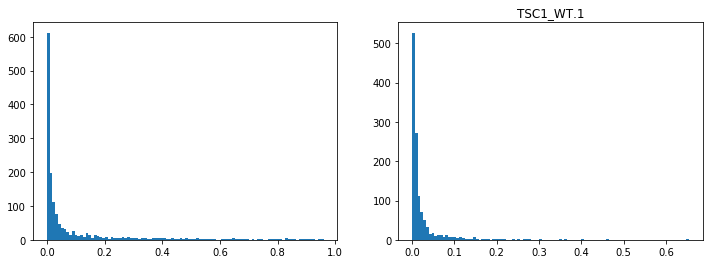

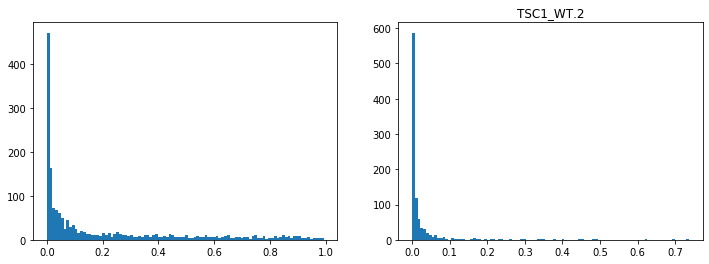

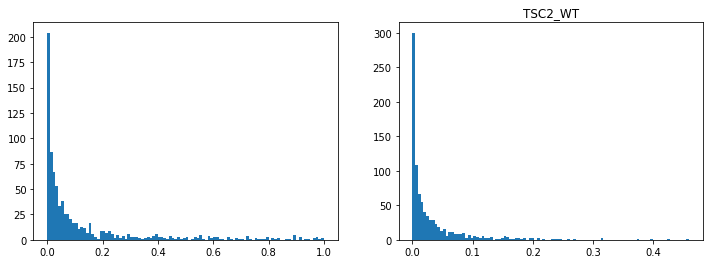

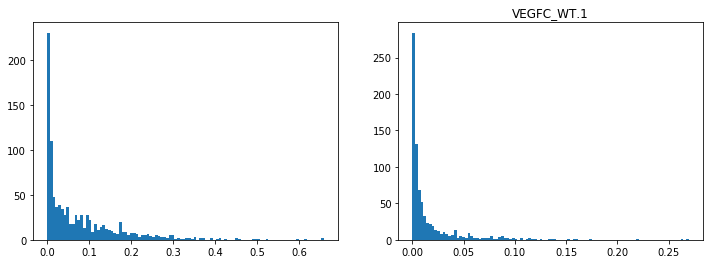

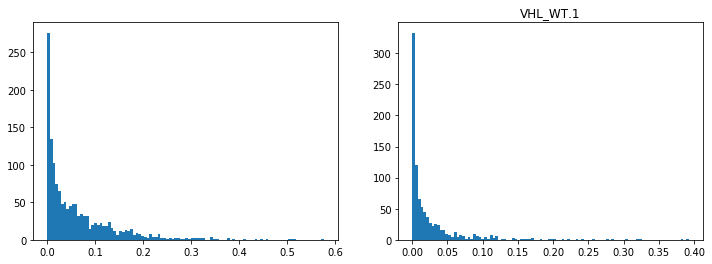

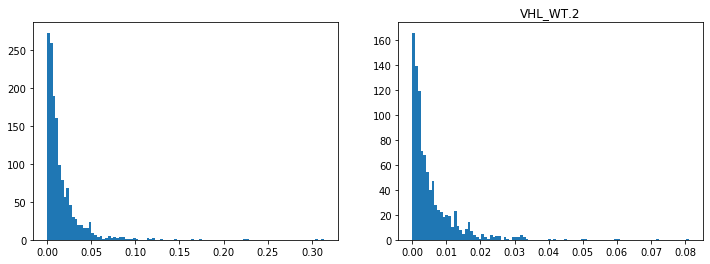

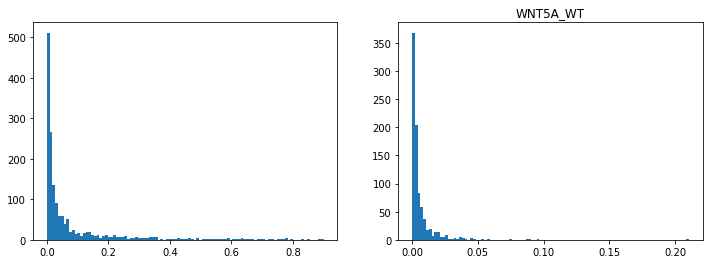

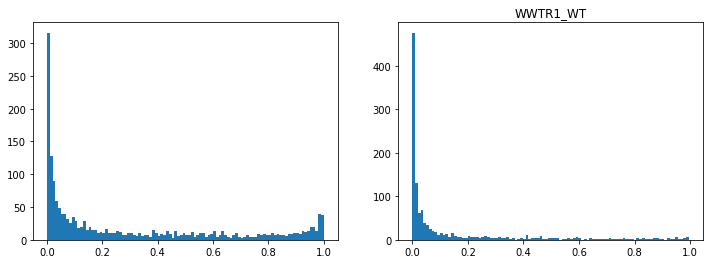

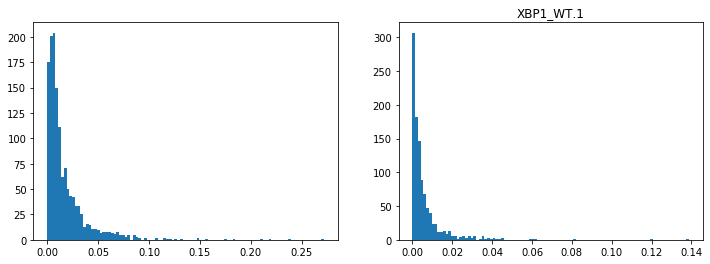

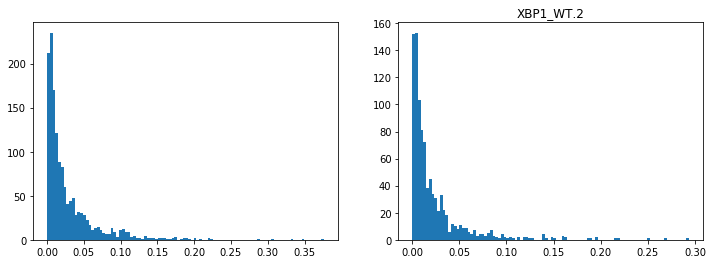

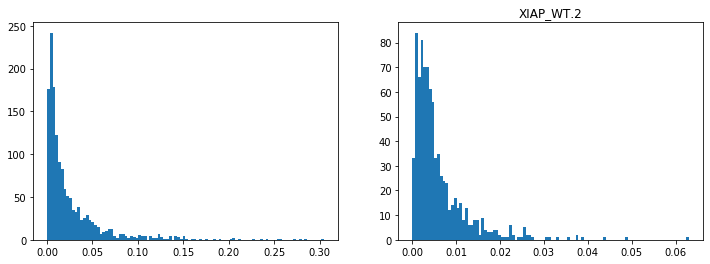

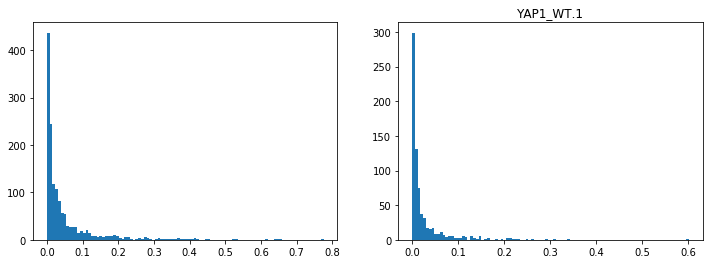

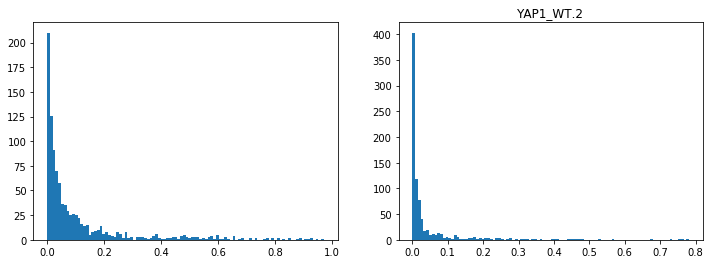

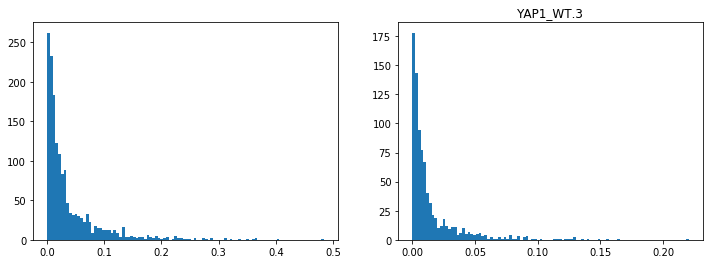

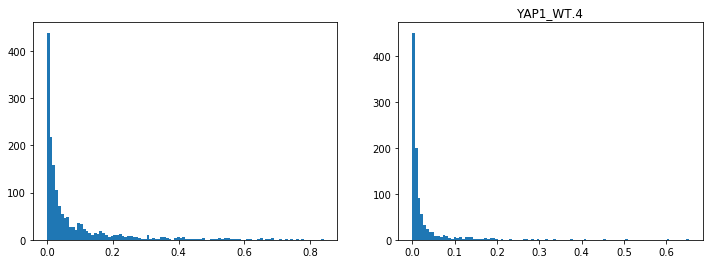

In [22]:
for k in class_ids.keys():
    #plt.figure()
    fig, ax = plt.subplots(1, 2, figsize=(12,4))
    h1 = ax[0].hist(training_set.loc[fullset.pert_name == k, class_ids[k]], bins=100)
    h2 = ax[1].hist(validation_set.loc[fullset.pert_name == k, class_ids[k]], bins=100)
    plt.title(k)

'EMPTY_'

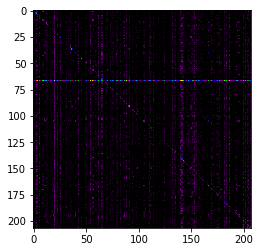

In [197]:
from sklearn.metrics import confusion_matrix
conf_matrix_val = confusion_matrix(validation_set["pert_name"], validation_set["Prediction"])
plt.imshow(conf_matrix_val, cmap="nipy_spectral")
class_names[np.argmax(np.sum(conf_matrix_val, axis=(1)))]

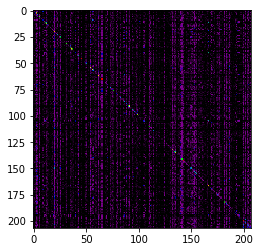

In [198]:
plt.imshow(conf_matrix_val / (np.sum(conf_matrix_val, axis=1, keepdims=True) + 0.1), cmap="nipy_spectral")

'EMPTY_'

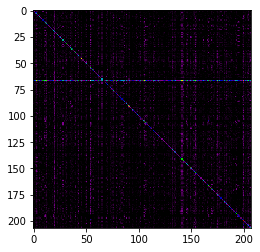

In [199]:
conf_matrix_train = confusion_matrix(training_set["pert_name"], training_set["Prediction"])
plt.imshow(conf_matrix_train, cmap="nipy_spectral")
class_names[np.argmax(np.sum(conf_matrix_train, axis=(1)))]

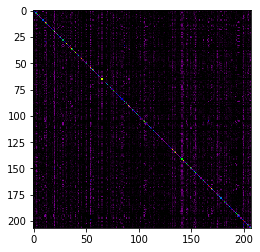

In [200]:
plt.imshow(conf_matrix_train / (np.sum(conf_matrix_train, axis=1, keepdims=True) + 0.1), cmap="nipy_spectral")

# Candidates Analysis

In [70]:
candidates = pd.read_csv("/dgx1nas1/storage/data/nmoshkov/DeepProfilerExperiments/candidates_metadata.csv")

In [82]:
simple1 = candidates.groupby(["Dataset", "Treatment"]).count().reset_index()
simple1 = simple1[["Dataset", "Treatment"]]
simple1["BroadSample"] = simple1.Treatment.str.split("@", expand=True)[0]

In [141]:
brd_parts = simple1.BroadSample.str.split("-", expand=True)
brd_parts[5] = brd_parts[0]
brd_parts.loc[~brd_parts[1].isna(), 5] = brd_parts[0] + "-" + brd_parts[1]
simple1["Real_Broad_Name"] = brd_parts[5]

In [142]:
simple1.groupby("Dataset")["Real_Broad_Name"].count()

Dataset
BBBC022    534
CDRP       269
TA-ORF      47
Name: Real_Broad_Name, dtype: int64

In [143]:
len(simple1.Real_Broad_Name.unique())

779

In [90]:
cdrp = pd.read_csv("/dgx1nas1/cellpainting-datasets/CDRP/inputs/metadata/index.csv")

In [96]:
len(cdrp.Compound.unique())

2240

In [91]:
bbbc022 = pd.read_csv("/dgx1nas1/cellpainting-datasets/BBBC022/inputs/metadata/index.csv")

In [99]:
len(bbbc022.Compound.unique())

1601

In [111]:
union = len(set(list(cdrp.Compound.unique()) + list(bbbc022.Compound.unique())))
intersection = len(set(cdrp.Compound.unique()).intersection(set(bbbc022.Compound.unique())))
onlyBBBC022 = len(bbbc022.Compound.unique()) - intersection
onlyCDRP = len(cdrp.Compound.unique()) - intersection

In [121]:
onlyCDRP, intersection, onlyBBBC022

(1347, 893, 708)

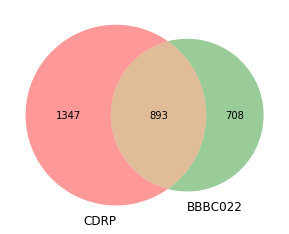

In [118]:
from matplotlib_venn import venn2
venn2(subsets = (onlyCDRP, onlyBBBC022, intersection), set_labels = ('CDRP', 'BBBC022'))

In [144]:
new_int = len(
    set(
        simple1[simple1.Dataset == "BBBC022"].Real_Broad_Name.unique()
    ).intersection(
        set(
            simple1[simple1.Dataset == "CDRP"].Real_Broad_Name.unique()
        )
    )
)


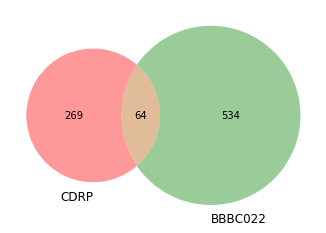

In [145]:
venn2(subsets = (269, 534, new_int), set_labels = ('CDRP', 'BBBC022'))